# Импорты

In [ ]:
!pip install catboost -q
!pip install ipynbname -q
!pip install optuna
!pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from google.colab import drive
import ipynbname
import shutil

import datetime
import pytz

import os

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Константы

In [ ]:
SEED = 42
MODE = 'validation'

# paths
DRIVE_PATH = './gdrive/MyDrive/ml_hits_1_module'
TRAIN_FILE_NAME = 'train.csv'
TEST_FILE_NAME = 'test.csv'
SUBMISSION_FILE_NAME = 'sample_submission.csv'
DATA_PATH = DRIVE_PATH + '/data'
SUBS_PATH = DRIVE_PATH + '/submits'
NOTEBOOKS_PATH = DRIVE_PATH + '/notebooks'

# Вспомогательные функции

In [ ]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_all_seeds(SEED)

# Загрузка данных

In [ ]:
path = os.path.join(DATA_PATH, TRAIN_FILE_NAME)
train = pd.read_csv(path)
print(train.shape)
train.sample(5)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
304,0337_02,Mars,False,F/63/S,TRAPPIST-1e,19.0,False,417.0,349.0,634.0,3.0,1057.0,Weros Perle,True
2697,2891_01,Earth,False,G/460/S,TRAPPIST-1e,18.0,False,4.0,904.0,0.0,0.0,1.0,Gleney Ortinericey,False
8424,8998_01,Earth,True,G/1449/S,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,Gerry Englence,False
1672,1771_01,Earth,False,G/291/P,TRAPPIST-1e,35.0,False,0.0,338.0,436.0,NaN,0.0,Antone Cardner,True
8458,9034_02,Europa,True,D/288/P,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Errairk Crakete,True


In [ ]:
path = os.path.join(DATA_PATH, TEST_FILE_NAME)
test = pd.read_csv(path)
print(test.shape)
test.sample(5)

(4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
2824,6244_01,Europa,False,A/61/P,TRAPPIST-1e,37.0,False,213.0,5.0,0.0,439.0,1190.0,Atino Spopting
2117,4583_03,Mars,False,D/146/S,TRAPPIST-1e,50.0,False,953.0,1628.0,1184.0,0.0,1.0,Per Parte
1332,2850_03,Mars,False,E/192/S,TRAPPIST-1e,26.0,False,1208.0,90.0,1.0,0.0,0.0,Shog Nuthe
3749,8183_01,Earth,False,E/526/P,TRAPPIST-1e,51.0,False,0.0,0.0,7.0,365.0,625.0,Jayne Hayder
2827,6255_01,Europa,True,B/212/P,TRAPPIST-1e,42.0,False,0.0,0.0,0.0,0.0,0.0,Schird Siccertful


# Обработка данных

In [ ]:
train.head(50)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


# EDA

## Преобразование фичей

In [ ]:
!pip install gender-guesser
import gender_guesser.detector as gender # Предсказание пола

gender_detector = gender.Detector()

In [ ]:
def predict_gender(name):
    first_name = name
    gender_pred = gender_detector.get_gender(first_name)
    # Упрощаем результат: 'male' или 'female', остальное считаем 'unknown'
    if gender_pred in ['male', 'mostly_male']:
        return 'male'
    elif gender_pred in ['female', 'mostly_female']:
        return 'female'
    else:
        return 'unknown'

In [ ]:
num_features = ['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                'PassengerNumberInGroup', 'Num', 'PaidSum', 'PassengersCountInGroup']

In [ ]:
def generate_num_features(df):
    df_transformed = df.copy()

    for feature in num_features:
        print(feature)

        df_transformed[f'{feature}_log'] = np.log1p(df[feature])
        df_transformed[f'{feature}_sqrt'] = np.sqrt(df[feature])

    pt_yeojohnson = PowerTransformer(method='yeo-johnson', standardize=False)
    yeojohnson_data = pt_yeojohnson.fit_transform(df[num_features])
    for i, feature in enumerate(num_features):
        df_transformed[f'{feature}_yeojohnson'] = yeojohnson_data[:, i]

    pt_boxcox = PowerTransformer(method='box-cox', standardize=False)
    boxcox_data = pt_boxcox.fit_transform(df[num_features] + 1)
    for i, feature in enumerate(num_features):
        df_transformed[f'{feature}_power_boxcox'] = boxcox_data[:, i]

    pt_yeojohnson_power = PowerTransformer(method='yeo-johnson', standardize=False)
    yeojohnson_power_data = pt_yeojohnson_power.fit_transform(df[num_features])
    for i, feature in enumerate(num_features):
        df_transformed[f'{feature}_power_yeojohnson'] = yeojohnson_power_data[:, i]

    return df_transformed

In [ ]:
def apply_tfidf_svd(df, text_column, max_features=1000, n_components=5):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    svd = TruncatedSVD(n_components)

    vectors = vectorizer.fit_transform(df[text_column])
    x_sv = svd.fit_transform(vectors)
    tfidf_df = pd.DataFrame(x_sv)
    cols = [(text_column + "_tfidf_" + str(f)) for f in tfidf_df.columns.to_list()]
    tfidf_df.columns = cols

    df = df.reset_index(drop=True)
    df = pd.concat([df, tfidf_df], axis="columns")

    return df

In [ ]:
def process_features(df):
    # Разбиваем на PassengerId на PassengerGroup и PassengerNumberInGroup
    df['PassengerGroup'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    df['PassengerNumberInGroup'] = df['PassengerId'].apply(lambda x: int(x.split('_')[1]))

    # Разбиваем Cabin на Deck, Num, Side
    df['Cabin'] = df['Cabin'].astype(str)
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if x != 'nan' else np.nan)
    df['Num'] = df['Cabin'].apply(lambda x: int(x.split('/')[1]) if x != 'nan' else np.nan)
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if x != 'nan' else np.nan)

    # Разбиваем Name на Surname и Name
    df['Name'] = df['Name'].fillna('Unknown Unknown') # Если имя неизвестно
    df['Surname'] = df['Name'].apply(lambda x: x.split()[1])
    df['Name'] = df['Name'].apply(lambda x: x.split()[0])

    # Придумываем новые фичи

    # Сколько всего заплатил пассажир
    df['PaidSum'] = (df['RoomService'] + df['FoodCourt'] +
                     df['ShoppingMall'] + df['Spa'] +
                     df['VRDeck'])
    # Платил ли пассажир за доп услуги
    df['PaidExtra'] = (df['RoomService'] + df['FoodCourt'] +
                       df['ShoppingMall'] + df['Spa'] +
                       df['VRDeck'] != 0.0)
    # Сколько человек в группе пассажира
    df['PassengersCountInGroup'] = df.groupby('PassengerGroup')['PassengerNumberInGroup'].transform('max')
    # В одиночку ли путешествует
    df['IsAlone'] = (df['PassengersCountInGroup'] == 1) & (df['PassengerNumberInGroup'] == 1)
    # Путешествует ли с родственниками
    df['IsTravelWithFamily'] = df.groupby('PassengerGroup')['Surname'].transform(lambda x: (x == x.iloc[0]).sum() > 1)
    # Пытаемся понять пол по имени
    df['Gender'] = df['Name'].apply(predict_gender)
    # Категория от возраста
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 18, 30, 50, 80], labels=['Child', 'YoungAdult', 'Adult', 'Senior'])

    df['VIPSpendMultiplier'] = (df['VIP'] * df['PaidSum']).apply(lambda x: 1e-6 if x == 0.0 else x).astype(float)

    df = generate_num_features(df)

    # Apply tf-idf
    df = apply_tfidf_svd(df, 'Name', n_components=5)
    df = apply_tfidf_svd(df, 'Surname', n_components=5)
    df = apply_tfidf_svd(df, 'Cabin', n_components=5)

    # Удаляем лишнее
    cols2drop = ['PassengerId', 'Cabin', 'Name', 'Surname']
    df = df.drop(cols2drop, axis=1, errors='ignore')

    return df

In [ ]:
train = process_features(train)

Age
FoodCourt
ShoppingMall
Spa
VRDeck
PassengerNumberInGroup
Num
PaidSum
PassengersCountInGroup


### Применение изменений

In [ ]:
target = ['Transported']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination',
                'VIP', 'Deck', 'Side', 'PaidExtra', 'IsAlone',
                'IsTravelWithFamily', 'Gender', 'AgeGroup']

text_features = [
    'Name_tfidf_0',	'Name_tfidf_1',	'Name_tfidf_2',	'Name_tfidf_3', 'Name_tfidf_4',
    'Surname_tfidf_0',	'Surname_tfidf_1',	'Surname_tfidf_2',	'Surname_tfidf_3', 'Surname_tfidf_4',
    'Cabin_tfidf_0',	'Cabin_tfidf_1',	'Cabin_tfidf_2',	'Cabin_tfidf_3',	'Cabin_tfidf_4'
    ]

filtered_features = [i for i in train.columns if (i not in target)]
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', target)

cat_features : 11 ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'PaidExtra', 'IsAlone', 'IsTravelWithFamily', 'Gender', 'AgeGroup']
num_features : 72 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerGroup', 'PassengerNumberInGroup', 'Num', 'PaidSum', 'PassengersCountInGroup', 'VIPSpendMultiplier', 'Age_log', 'Age_sqrt', 'FoodCourt_log', 'FoodCourt_sqrt', 'ShoppingMall_log', 'ShoppingMall_sqrt', 'Spa_log', 'Spa_sqrt', 'VRDeck_log', 'VRDeck_sqrt', 'PassengerNumberInGroup_log', 'PassengerNumberInGroup_sqrt', 'Num_log', 'Num_sqrt', 'PaidSum_log', 'PaidSum_sqrt', 'PassengersCountInGroup_log', 'PassengersCountInGroup_sqrt', 'Age_yeojohnson', 'FoodCourt_yeojohnson', 'ShoppingMall_yeojohnson', 'Spa_yeojohnson', 'VRDeck_yeojohnson', 'PassengerNumberInGroup_yeojohnson', 'Num_yeojohnson', 'PaidSum_yeojohnson', 'PassengersCountInGroup_yeojohnson', 'Age_power_boxcox', 'FoodCourt_power_boxcox', 'ShoppingMall_power_boxcox', 'Spa_power_boxcox', 'VRDeck

In [ ]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,Cabin_tfidf_0,Cabin_tfidf_1,Cabin_tfidf_2,Cabin_tfidf_3,Cabin_tfidf_4
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,3.674156e-11,0.000001,0.000027,-0.000073,-0.000332,0.0,0.0,0.0,0.0,0.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,-1.833931e-10,-0.000052,0.000213,0.000556,0.001259,0.0,0.0,0.0,0.0,0.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,-1.833931e-10,-0.000052,0.000213,0.000556,0.001259,0.0,0.0,0.0,0.0,0.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,-4.494386e-11,-0.000716,0.001185,0.000046,0.002975,0.0,0.0,0.0,0.0,0.0


## Пропуски

In [ ]:
train.isna().sum().sort_values(ascending=False)

,0
VIPSpendMultiplier,1096
PaidSum,908
PaidSum_power_yeojohnson,908
PaidSum_yeojohnson,908
PaidSum_sqrt,908
...,...
PassengerNumberInGroup_log,0
PassengerNumberInGroup_sqrt,0
PassengersCountInGroup_log,0
PassengersCountInGroup_yeojohnson,0


In [ ]:
train.shape

(8693, 84)

Пробуем заменить

In [ ]:
def replace_nans(df):
  # Численные фичи заполняем медианами
  for feature in num_features:
      train[feature] = train[feature].astype(float)

  median_values = train[num_features].median()
  df[num_features] = df[num_features].fillna(median_values)

  # Несбалансированные категориальные фичи заполняем самым популярным классом
  disbalanced_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Gender']

  for feature in disbalanced_features:
      df[feature] = df[feature].fillna(train[feature].mode()[0])

  # Остальные категориальные фичи заполняем 'NoInformation'
  balanced_features = [i for i in cat_features if i not in disbalanced_features]

  for feature in balanced_features:
    if pd.api.types.is_categorical_dtype(df[feature]):
        df[feature] = df[feature].cat.add_categories('NoInformation')
    df[feature] = df[feature].fillna('NoInformation')

  return df

In [ ]:
train = replace_nans(train)

<ipython-input-337-e0d2d97f7bb2>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = df[feature].fillna(train[feature].mode()[0])
<ipython-input-337-e0d2d97f7bb2>:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


In [ ]:
def update_types(df):
  for col in cat_features:
        df[col] = df[col].astype('category')

  return df

In [ ]:
train = update_types(train)

# Графики

### Офигеваем с выбросов

In [ ]:
train.hist(figsize=(20,15))

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>,
        <Axes: title={'center': 'ShoppingMall'}>,
        <Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>,
        <Axes: title={'center': 'PassengerGroup'}>,
        <Axes: title={'center': 'PassengerNumberInGroup'}>],
       [<Axes: title={'center': 'Num'}>,
        <Axes: title={'center': 'PaidSum'}>,
        <Axes: title={'center': 'PassengersCountInGroup'}>,
        <Axes: title={'center': 'VIPSpendMultiplier'}>,
        <Axes: title={'center': 'Age_log'}>,
        <Axes: title={'center': 'Age_sqrt'}>,
        <Axes: title={'center': 'FoodCourt_log'}>,
        <Axes: title={'center': 'FoodCourt_sqrt'}>],
       [<Axes: title={'center': 'ShoppingMall_log'}>,
        <Axes: title={'center': 'ShoppingMall_sqrt'}>,
        <Axes: title={'center': 'Spa_log'}>,
        <Axes: title={'center': 'Spa_sqrt'}>,
        <Axes: tit

Error in callback <function flush_figures at 0x7c2ecf267060> (for post_execute):


KeyboardInterrupt: 

Выбросы?

Пробуем удалить

In [ ]:
# def delete_outliers(df, quantile_size=0.01):
#     for feature in num_features:
#         Q1 = df[feature].quantile(quantile_size)
#         Q3 = df[feature].quantile(1 - quantile_size)
#         IQR = Q3 - Q1

#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

#     return df

In [ ]:
# train.shape[0]

8693

In [ ]:
# train = delete_outliers(train)
# train.shape[0]

8648

### Смотрим категориальные фичи

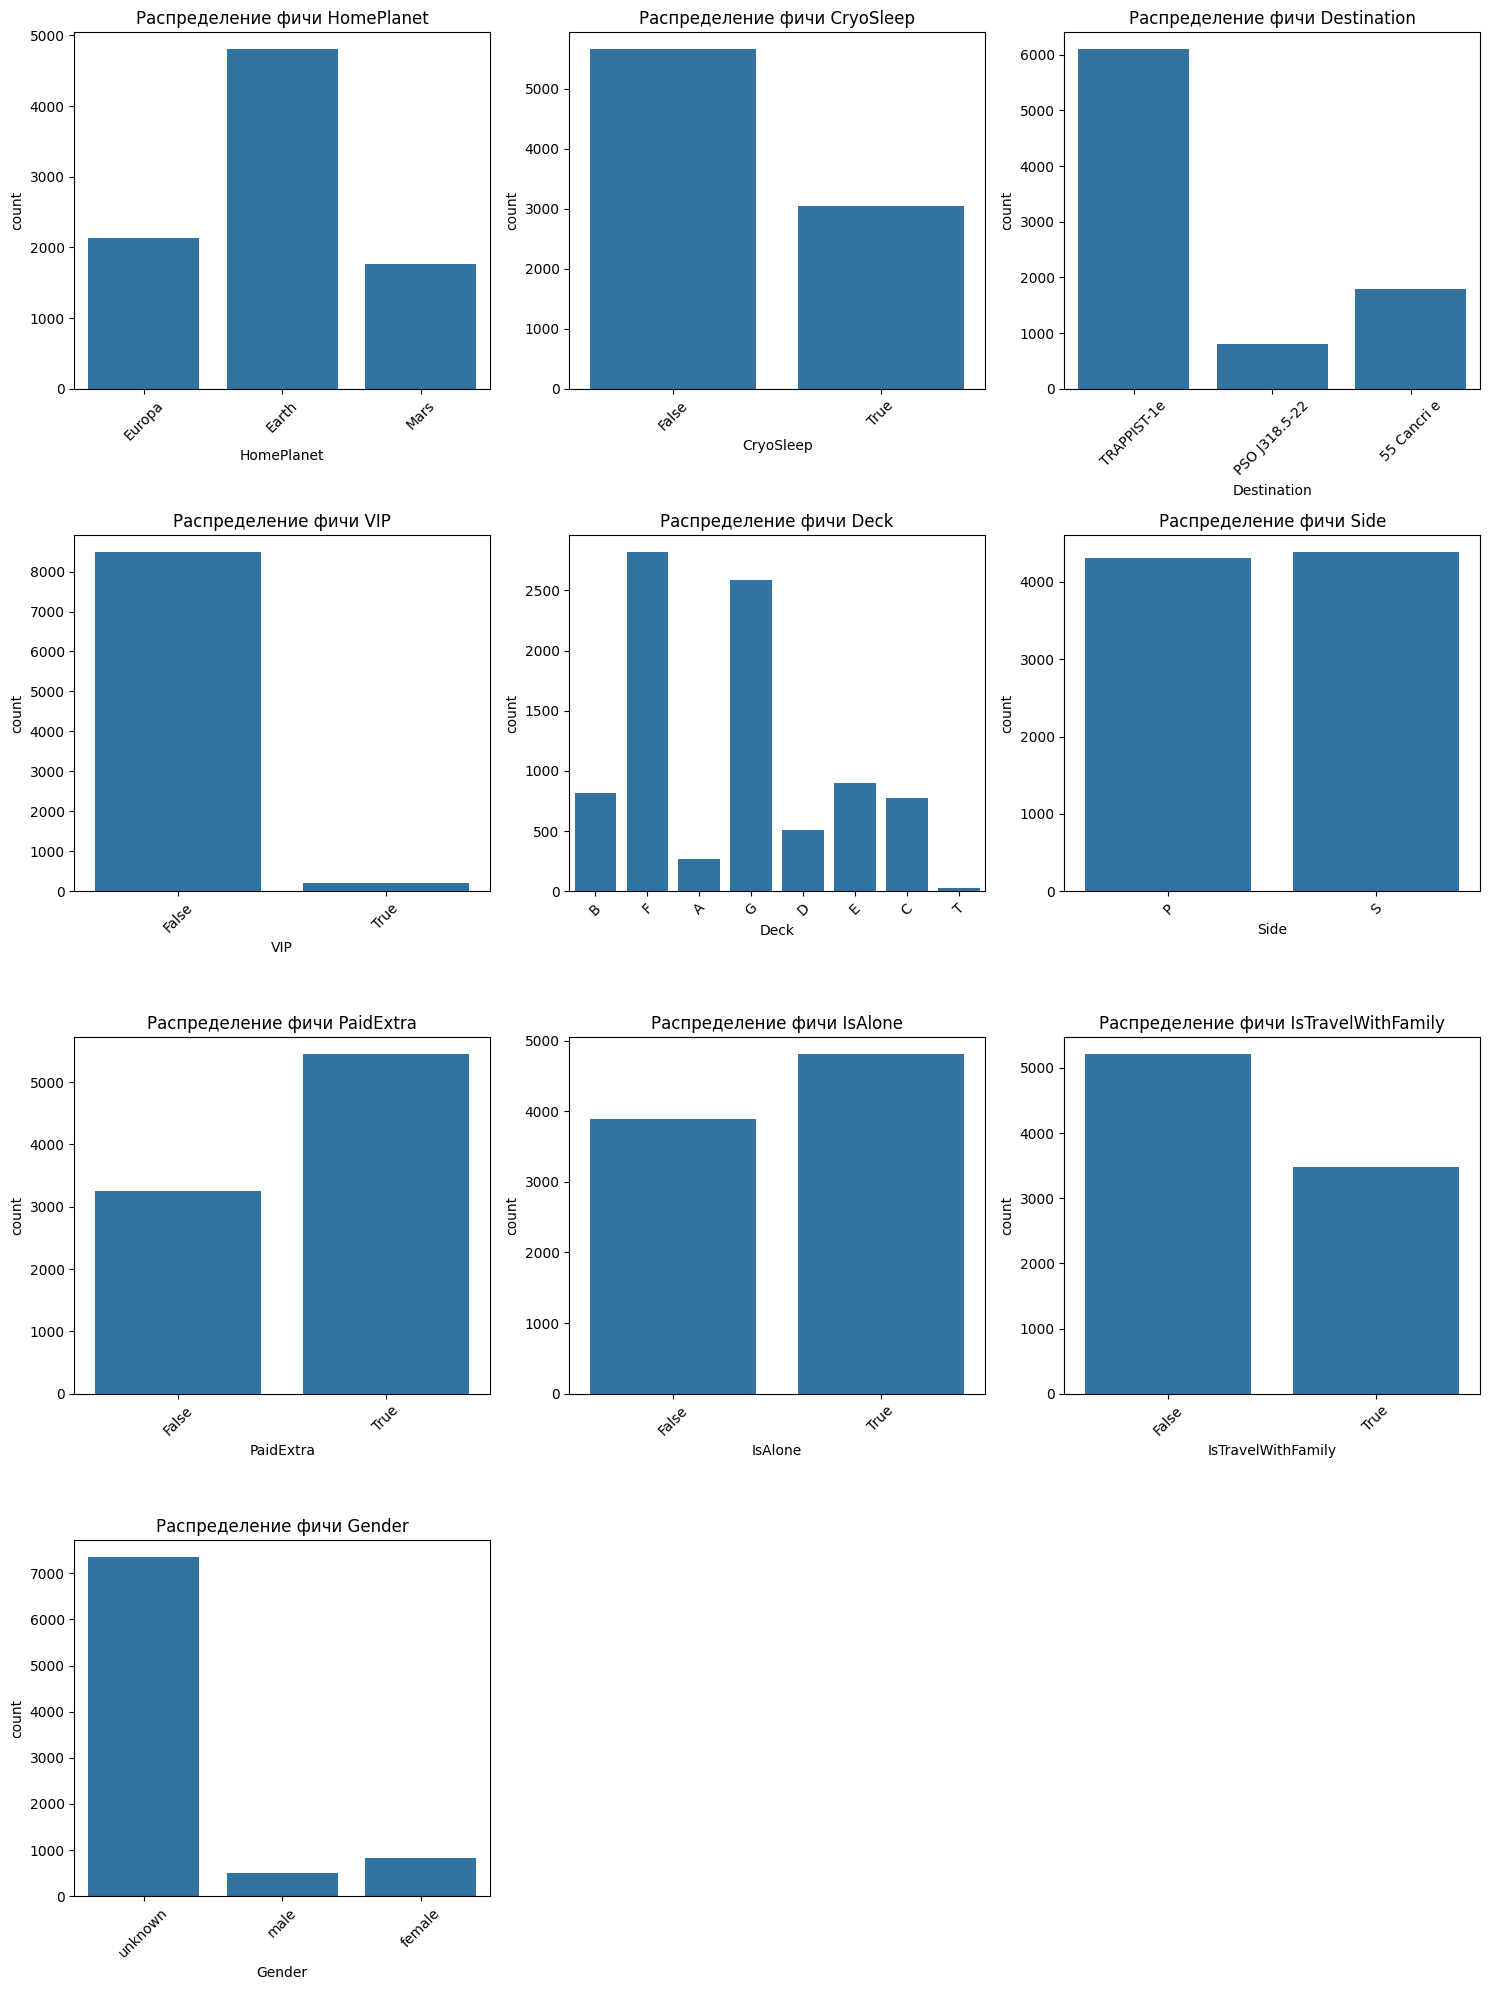

In [ ]:
n_cols = 3
n_rows = (len(cat_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, data=train, ax=axes[i])
    axes[i].set_title(f'Распределение фичи {feature}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Смотрим че там с таргетом

In [ ]:
train['Transported'].value_counts()

,count
Transported,
True,4378
False,4315


Таргет сбалансирован ура

In [ ]:
from sklearn.preprocessing import LabelEncoder
def show_corr_matrix(data):
    data_new = data.copy()
    for col in cat_features:
        data_new[col] = LabelEncoder().fit_transform(data[col])

    sns.heatmap(data_new.corr())

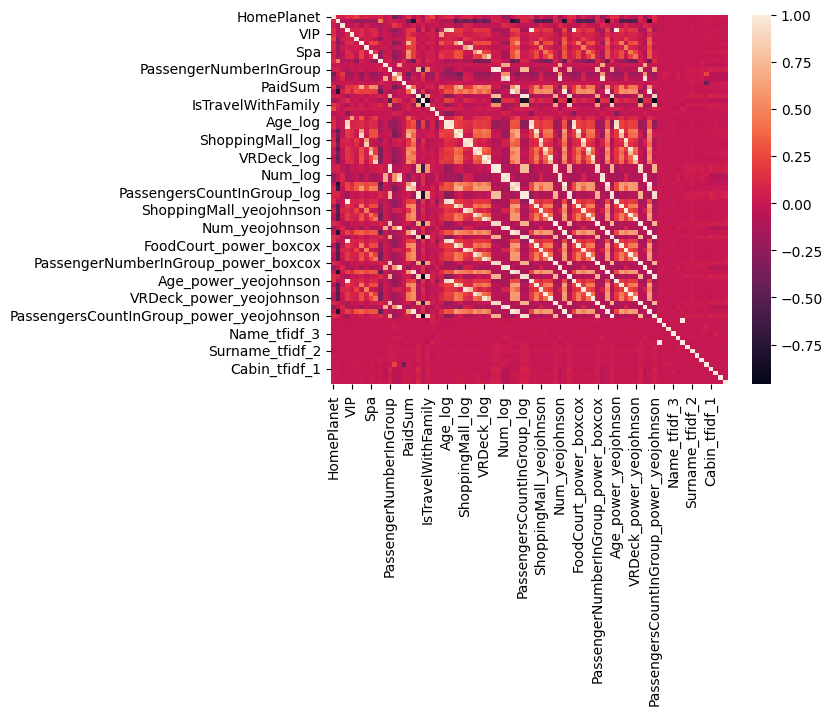

In [ ]:
show_corr_matrix(train)

In [ ]:
pd.crosstab(
    train['CryoSleep'],
    train['Transported']
).style.background_gradient('RdYlGn')

Transported,False,True
CryoSleep,,
False,3761,1895
True,554,2483


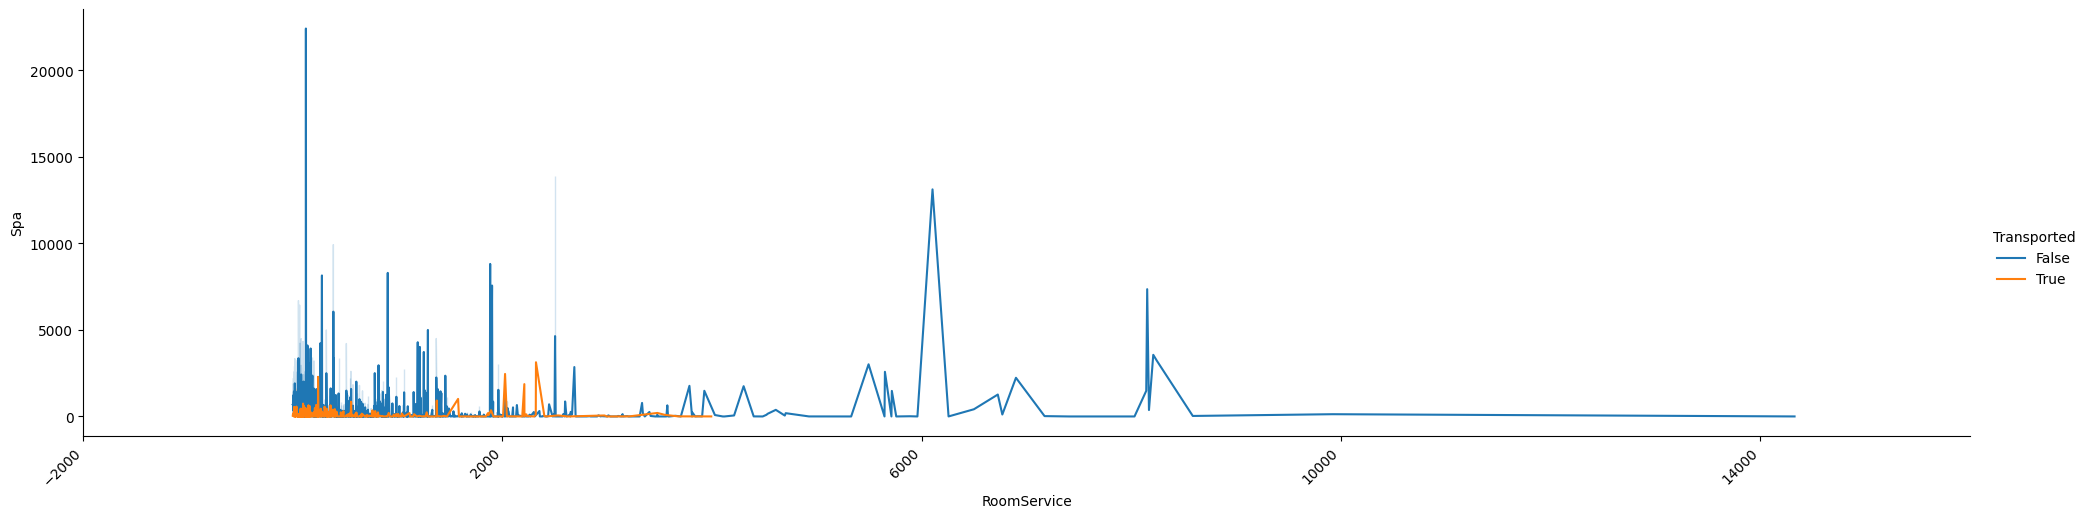

In [ ]:
sns.relplot(
    data=train,
    kind='line',
    x='RoomService',
    y='Spa',
    hue='Transported',
    aspect=4
).set_xticklabels(rotation=45, horizontalalignment='right', step=2)

## Графики

# Обучение

In [ ]:
X = train.drop(target, axis=1, errors='ignore')
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

In [ ]:
def objective(trial):
    params = {
        'cat_features': cat_features,
        'random_state': SEED,

        # Базовые параметры
        'n_estimators':  trial.suggest_categorical('n_estimators', [500, 1500]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 8),

        # Регуляризация
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=150,
        plot=False
    )

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-03-05 19:16:10,725] A new study created in memory with name: no-name-85303200-8fbc-4009-a5cb-a1da9cfb628b


0:	learn: 0.6883518	test: 0.6886515	best: 0.6886515 (0)	total: 32.9ms	remaining: 16.4s
150:	learn: 0.4605906	test: 0.4811041	best: 0.4811041 (150)	total: 3.64s	remaining: 8.41s
300:	learn: 0.4222883	test: 0.4505498	best: 0.4505498 (300)	total: 5.93s	remaining: 3.92s
450:	learn: 0.4043019	test: 0.4360958	best: 0.4360958 (450)	total: 8.27s	remaining: 898ms


[I 2025-03-05 19:16:19,981] Trial 0 finished with value: 0.7873563218390804 and parameters: {'n_estimators': 500, 'learning_rate': 0.013795967024481697, 'depth': 4, 'l2_leaf_reg': 6.175467237333697, 'random_strength': 0.7559365918872349, 'bagging_temperature': 0.08875844089168361, 'border_count': 45}. Best is trial 0 with value: 0.7873563218390804.


499:	learn: 0.4003331	test: 0.4334882	best: 0.4334882 (499)	total: 9.04s	remaining: 0us

bestTest = 0.4334882455
bestIteration = 499

0:	learn: 0.5885068	test: 0.5961703	best: 0.5961703 (0)	total: 31.6ms	remaining: 47.4s
150:	learn: 0.2410416	test: 0.4144010	best: 0.4107596 (93)	total: 4.99s	remaining: 44.6s
300:	learn: 0.1552945	test: 0.4304653	best: 0.4107596 (93)	total: 10.7s	remaining: 42.7s
450:	learn: 0.1028435	test: 0.4422391	best: 0.4107596 (93)	total: 15.1s	remaining: 35s
600:	learn: 0.0738784	test: 0.4574367	best: 0.4107596 (93)	total: 21.2s	remaining: 31.7s
750:	learn: 0.0545638	test: 0.4796047	best: 0.4107596 (93)	total: 25.7s	remaining: 25.6s
900:	learn: 0.0424219	test: 0.4931613	best: 0.4107596 (93)	total: 30.5s	remaining: 20.3s
1050:	learn: 0.0332141	test: 0.5100110	best: 0.4107596 (93)	total: 36.8s	remaining: 15.7s
1200:	learn: 0.0272209	test: 0.5233289	best: 0.4107596 (93)	total: 41.2s	remaining: 10.2s
1350:	learn: 0.0227876	test: 0.5352341	best: 0.4107596 (93)	total: 

[I 2025-03-05 19:17:12,624] Trial 1 finished with value: 0.7988505747126436 and parameters: {'n_estimators': 1500, 'learning_rate': 0.22102004190580446, 'depth': 6, 'l2_leaf_reg': 5.459146145496223, 'random_strength': 0.06644639027858622, 'bagging_temperature': 0.5873461204783106, 'border_count': 155}. Best is trial 1 with value: 0.7988505747126436.


1499:	learn: 0.0203121	test: 0.5478995	best: 0.4107596 (93)	total: 52.3s	remaining: 0us

bestTest = 0.4107596023
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 0.6877797	test: 0.6881784	best: 0.6881784 (0)	total: 25.2ms	remaining: 37.7s
150:	learn: 0.4382555	test: 0.4657636	best: 0.4657636 (150)	total: 3.64s	remaining: 32.5s
300:	learn: 0.3952816	test: 0.4347883	best: 0.4347883 (300)	total: 6.98s	remaining: 27.8s
450:	learn: 0.3714413	test: 0.4225084	best: 0.4225062 (449)	total: 12s	remaining: 27.9s
600:	learn: 0.3547798	test: 0.4176539	best: 0.4176539 (600)	total: 15.2s	remaining: 22.8s
750:	learn: 0.3410848	test: 0.4140853	best: 0.4140058 (748)	total: 18.6s	remaining: 18.5s
900:	learn: 0.3289871	test: 0.4115811	best: 0.4115290 (894)	total: 23.1s	remaining: 15.4s
1050:	learn: 0.3179531	test: 0.4090572	best: 0.4090572 (1050)	total: 26.9s	remaining: 11.5s
1200:	learn: 0.3075286	test: 0.4079464	best: 0.4079451 (1196)	total: 30.3s	remaining: 7.54s
1350:	learn: 0.297352

[I 2025-03-05 19:17:51,665] Trial 2 finished with value: 0.7988505747126436 and parameters: {'n_estimators': 1500, 'learning_rate': 0.01215744596223375, 'depth': 5, 'l2_leaf_reg': 0.001695129320659242, 'random_strength': 0.0027459687038187226, 'bagging_temperature': 0.09522841535386517, 'border_count': 154}. Best is trial 1 with value: 0.7988505747126436.


1499:	learn: 0.2879406	test: 0.4074511	best: 0.4072647 (1479)	total: 38.7s	remaining: 0us

bestTest = 0.4072646555
bestIteration = 1479

Shrink model to first 1480 iterations.
0:	learn: 0.6195755	test: 0.6253512	best: 0.6253512 (0)	total: 16.7ms	remaining: 8.35s
150:	learn: 0.2965005	test: 0.4323109	best: 0.4211632 (59)	total: 2.74s	remaining: 6.33s
300:	learn: 0.2198674	test: 0.4554161	best: 0.4211632 (59)	total: 5.43s	remaining: 3.59s
450:	learn: 0.1726167	test: 0.4572342	best: 0.4211632 (59)	total: 8.09s	remaining: 879ms


[I 2025-03-05 19:18:00,809] Trial 3 finished with value: 0.7908045977011494 and parameters: {'n_estimators': 500, 'learning_rate': 0.2546164916470041, 'depth': 4, 'l2_leaf_reg': 0.10104211521725862, 'random_strength': 1.3488760860383182, 'bagging_temperature': 0.6750809496752329, 'border_count': 178}. Best is trial 1 with value: 0.7988505747126436.


499:	learn: 0.1585210	test: 0.4635677	best: 0.4211632 (59)	total: 8.96s	remaining: 0us

bestTest = 0.4211631709
bestIteration = 59

Shrink model to first 60 iterations.
0:	learn: 0.6601164	test: 0.6633266	best: 0.6633266 (0)	total: 80.2ms	remaining: 2m
150:	learn: 0.2366452	test: 0.4315188	best: 0.4247981 (134)	total: 15.8s	remaining: 2m 20s
300:	learn: 0.1072946	test: 0.4639878	best: 0.4247981 (134)	total: 29.7s	remaining: 1m 58s
450:	learn: 0.0519671	test: 0.4991952	best: 0.4247981 (134)	total: 43.1s	remaining: 1m 40s
600:	learn: 0.0265276	test: 0.5324201	best: 0.4247981 (134)	total: 56.8s	remaining: 1m 24s
750:	learn: 0.0140856	test: 0.5607256	best: 0.4247981 (134)	total: 1m 11s	remaining: 1m 11s
900:	learn: 0.0077697	test: 0.5861262	best: 0.4247981 (134)	total: 1m 24s	remaining: 56s
1050:	learn: 0.0044766	test: 0.6222561	best: 0.4247981 (134)	total: 1m 36s	remaining: 41.3s
1200:	learn: 0.0026956	test: 0.6506031	best: 0.4247981 (134)	total: 1m 49s	remaining: 27.2s
1350:	learn: 0.002

[I 2025-03-05 19:20:15,726] Trial 4 finished with value: 0.7873563218390804 and parameters: {'n_estimators': 1500, 'learning_rate': 0.07673622184950118, 'depth': 8, 'l2_leaf_reg': 0.018837639506332774, 'random_strength': 1.8037310028992612, 'bagging_temperature': 0.8699421647797598, 'border_count': 166}. Best is trial 1 with value: 0.7988505747126436.


1499:	learn: 0.0019393	test: 0.6679854	best: 0.4247981 (134)	total: 2m 14s	remaining: 0us

bestTest = 0.4247981124
bestIteration = 134

Shrink model to first 135 iterations.
0:	learn: 0.6111539	test: 0.6178480	best: 0.6178480 (0)	total: 63.3ms	remaining: 1m 34s
150:	learn: 0.1404549	test: 0.4699367	best: 0.4210991 (44)	total: 10.9s	remaining: 1m 37s
300:	learn: 0.0522614	test: 0.5319459	best: 0.4210991 (44)	total: 20s	remaining: 1m 19s
450:	learn: 0.0195094	test: 0.5991238	best: 0.4210991 (44)	total: 30.8s	remaining: 1m 11s
600:	learn: 0.0078949	test: 0.6564828	best: 0.4210991 (44)	total: 41.6s	remaining: 1m 2s
750:	learn: 0.0031939	test: 0.7142223	best: 0.4210991 (44)	total: 52.5s	remaining: 52.3s
900:	learn: 0.0020124	test: 0.7460348	best: 0.4210991 (44)	total: 1m 1s	remaining: 40.7s
1050:	learn: 0.0017607	test: 0.7541071	best: 0.4210991 (44)	total: 1m 11s	remaining: 30.5s
1200:	learn: 0.0016847	test: 0.7553062	best: 0.4210991 (44)	total: 1m 21s	remaining: 20.4s
1350:	learn: 0.001580

[I 2025-03-05 19:21:56,794] Trial 5 finished with value: 0.7954022988505747 and parameters: {'n_estimators': 1500, 'learning_rate': 0.1665024622375049, 'depth': 7, 'l2_leaf_reg': 0.002829312540901532, 'random_strength': 0.18060872265539346, 'bagging_temperature': 0.6577122118359342, 'border_count': 220}. Best is trial 1 with value: 0.7988505747126436.


1499:	learn: 0.0014841	test: 0.7661728	best: 0.4210991 (44)	total: 1m 40s	remaining: 0us

bestTest = 0.4210991244
bestIteration = 44

Shrink model to first 45 iterations.
0:	learn: 0.6586974	test: 0.6609616	best: 0.6609616 (0)	total: 29.9ms	remaining: 14.9s
150:	learn: 0.3178708	test: 0.4139330	best: 0.4138118 (146)	total: 6.07s	remaining: 14s
300:	learn: 0.2535566	test: 0.4068292	best: 0.4066933 (293)	total: 10.7s	remaining: 7.09s
450:	learn: 0.2044857	test: 0.4063945	best: 0.4046028 (392)	total: 14.9s	remaining: 1.62s


[I 2025-03-05 19:22:13,870] Trial 6 finished with value: 0.8080459770114943 and parameters: {'n_estimators': 500, 'learning_rate': 0.06377881472633684, 'depth': 6, 'l2_leaf_reg': 0.13444739426909352, 'random_strength': 0.0013867967636738675, 'bagging_temperature': 0.8985468576153325, 'border_count': 142}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.1899035	test: 0.4097228	best: 0.4046028 (392)	total: 16.9s	remaining: 0us

bestTest = 0.4046027704
bestIteration = 392

Shrink model to first 393 iterations.
0:	learn: 0.6816930	test: 0.6822088	best: 0.6822088 (0)	total: 49.2ms	remaining: 24.5s
150:	learn: 0.4138922	test: 0.4591160	best: 0.4591160 (150)	total: 5.1s	remaining: 11.8s
300:	learn: 0.3271726	test: 0.4161549	best: 0.4158056 (296)	total: 9.08s	remaining: 6s
450:	learn: 0.2611576	test: 0.4068356	best: 0.4064540 (449)	total: 15.7s	remaining: 1.71s


[I 2025-03-05 19:22:32,032] Trial 7 finished with value: 0.8057471264367816 and parameters: {'n_estimators': 500, 'learning_rate': 0.04580988155963975, 'depth': 6, 'l2_leaf_reg': 0.0025045121485096113, 'random_strength': 8.18740977823387, 'bagging_temperature': 0.3814552300445443, 'border_count': 117}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2442771	test: 0.4067556	best: 0.4064540 (449)	total: 17.9s	remaining: 0us

bestTest = 0.4064540422
bestIteration = 449

Shrink model to first 450 iterations.
0:	learn: 0.6486016	test: 0.6521374	best: 0.6521374 (0)	total: 23.7ms	remaining: 11.8s
150:	learn: 0.3264779	test: 0.4123012	best: 0.4122856 (149)	total: 3.79s	remaining: 8.76s
300:	learn: 0.2699029	test: 0.4132126	best: 0.4101276 (243)	total: 8.47s	remaining: 5.6s
450:	learn: 0.2237729	test: 0.4173573	best: 0.4101276 (243)	total: 13.9s	remaining: 1.51s


[I 2025-03-05 19:22:47,244] Trial 8 finished with value: 0.7965517241379311 and parameters: {'n_estimators': 500, 'learning_rate': 0.10744543052398588, 'depth': 5, 'l2_leaf_reg': 1.406793531691387, 'random_strength': 0.015950572372959302, 'bagging_temperature': 0.6773235323057211, 'border_count': 183}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2100444	test: 0.4197935	best: 0.4101276 (243)	total: 15s	remaining: 0us

bestTest = 0.4101276378
bestIteration = 243

Shrink model to first 244 iterations.
0:	learn: 0.6621264	test: 0.6626626	best: 0.6626626 (0)	total: 26.4ms	remaining: 13.2s
150:	learn: 0.3054179	test: 0.4334209	best: 0.4297146 (109)	total: 3.86s	remaining: 8.93s
300:	learn: 0.2159404	test: 0.4358766	best: 0.4259631 (220)	total: 10.2s	remaining: 6.74s
450:	learn: 0.1546680	test: 0.4542193	best: 0.4259631 (220)	total: 14.5s	remaining: 1.58s


[I 2025-03-05 19:23:03,146] Trial 9 finished with value: 0.7908045977011494 and parameters: {'n_estimators': 500, 'learning_rate': 0.14794812555359946, 'depth': 5, 'l2_leaf_reg': 0.010667681105392814, 'random_strength': 6.716553482085575, 'bagging_temperature': 0.36408957278998577, 'border_count': 220}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.1407032	test: 0.4612831	best: 0.4259631 (220)	total: 15.7s	remaining: 0us

bestTest = 0.4259630812
bestIteration = 220

Shrink model to first 221 iterations.
0:	learn: 0.6751685	test: 0.6769133	best: 0.6769133 (0)	total: 59.1ms	remaining: 29.5s
150:	learn: 0.3170538	test: 0.4181454	best: 0.4181158 (146)	total: 11.2s	remaining: 25.8s
300:	learn: 0.2469748	test: 0.4147241	best: 0.4147111 (299)	total: 20.9s	remaining: 13.8s
450:	learn: 0.1939875	test: 0.4122056	best: 0.4111643 (430)	total: 31.6s	remaining: 3.43s


[I 2025-03-05 19:23:39,234] Trial 10 finished with value: 0.8 and parameters: {'n_estimators': 500, 'learning_rate': 0.029039086099298225, 'depth': 8, 'l2_leaf_reg': 0.24250594360658045, 'random_strength': 0.0016079024889523084, 'bagging_temperature': 0.988813565376321, 'border_count': 89}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.1798730	test: 0.4114308	best: 0.4111643 (430)	total: 35.8s	remaining: 0us

bestTest = 0.4111643206
bestIteration = 430

Shrink model to first 431 iterations.
0:	learn: 0.6687946	test: 0.6702329	best: 0.6702329 (0)	total: 52.5ms	remaining: 26.2s
150:	learn: 0.3442139	test: 0.4149833	best: 0.4149833 (150)	total: 4.75s	remaining: 11s
300:	learn: 0.2937707	test: 0.4109385	best: 0.4101566 (247)	total: 8.99s	remaining: 5.94s
450:	learn: 0.2542643	test: 0.4092827	best: 0.4072104 (360)	total: 14.8s	remaining: 1.61s


[I 2025-03-05 19:23:55,846] Trial 11 finished with value: 0.7954022988505747 and parameters: {'n_estimators': 500, 'learning_rate': 0.044512135463350776, 'depth': 6, 'l2_leaf_reg': 0.3399972382768773, 'random_strength': 0.02046961317442102, 'bagging_temperature': 0.32745908856199196, 'border_count': 105}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2429328	test: 0.4095879	best: 0.4072104 (360)	total: 16.3s	remaining: 0us

bestTest = 0.4072104421
bestIteration = 360

Shrink model to first 361 iterations.
0:	learn: 0.6830848	test: 0.6838235	best: 0.6838235 (0)	total: 34.6ms	remaining: 17.2s
150:	learn: 0.4092956	test: 0.4550958	best: 0.4550958 (150)	total: 4.79s	remaining: 11.1s
300:	learn: 0.3360598	test: 0.4196780	best: 0.4196780 (300)	total: 11.3s	remaining: 7.46s
450:	learn: 0.2529429	test: 0.4072042	best: 0.4072005 (401)	total: 17.5s	remaining: 1.9s


[I 2025-03-05 19:24:15,585] Trial 12 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 500, 'learning_rate': 0.03794263353221196, 'depth': 7, 'l2_leaf_reg': 0.01935822396684401, 'random_strength': 7.156368475652259, 'bagging_temperature': 0.3896705997083266, 'border_count': 104}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2324655	test: 0.4073406	best: 0.4064450 (455)	total: 19.5s	remaining: 0us

bestTest = 0.4064450158
bestIteration = 455

Shrink model to first 456 iterations.
0:	learn: 0.6783905	test: 0.6796565	best: 0.6796565 (0)	total: 44.4ms	remaining: 22.1s
150:	learn: 0.3530858	test: 0.4225629	best: 0.4225629 (150)	total: 7.61s	remaining: 17.6s
300:	learn: 0.2952843	test: 0.4105371	best: 0.4105371 (300)	total: 13.4s	remaining: 8.87s
450:	learn: 0.2539017	test: 0.4080578	best: 0.4069000 (430)	total: 20.9s	remaining: 2.27s


[I 2025-03-05 19:24:38,639] Trial 13 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 500, 'learning_rate': 0.02520600411128715, 'depth': 7, 'l2_leaf_reg': 0.05822310852954339, 'random_strength': 0.007603463520529561, 'bagging_temperature': 0.2532033412734867, 'border_count': 124}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2408041	test: 0.4087116	best: 0.4069000 (430)	total: 22.8s	remaining: 0us

bestTest = 0.4068999718
bestIteration = 430

Shrink model to first 431 iterations.
0:	learn: 0.6597982	test: 0.6613417	best: 0.6613417 (0)	total: 24ms	remaining: 12s
150:	learn: 0.3267896	test: 0.4146581	best: 0.4135706 (145)	total: 3.54s	remaining: 8.19s
300:	learn: 0.2618083	test: 0.4155864	best: 0.4132455 (231)	total: 7.08s	remaining: 4.68s
450:	learn: 0.2137338	test: 0.4122458	best: 0.4112211 (386)	total: 12.6s	remaining: 1.36s


[I 2025-03-05 19:24:52,612] Trial 14 finished with value: 0.7977011494252874 and parameters: {'n_estimators': 500, 'learning_rate': 0.06824989235115572, 'depth': 6, 'l2_leaf_reg': 0.5743015773099681, 'random_strength': 0.20676194255394975, 'bagging_temperature': 0.8294869884807942, 'border_count': 63}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2008963	test: 0.4128852	best: 0.4112211 (386)	total: 13.8s	remaining: 0us

bestTest = 0.411221141
bestIteration = 386

Shrink model to first 387 iterations.
0:	learn: 0.6793079	test: 0.6805451	best: 0.6805451 (0)	total: 64.4ms	remaining: 32.1s
150:	learn: 0.3460017	test: 0.4198193	best: 0.4198193 (150)	total: 11.4s	remaining: 26.3s
300:	learn: 0.2830775	test: 0.4135001	best: 0.4129859 (298)	total: 21.1s	remaining: 13.9s
450:	learn: 0.2363038	test: 0.4102800	best: 0.4101810 (439)	total: 32.5s	remaining: 3.53s


[I 2025-03-05 19:25:29,030] Trial 15 finished with value: 0.8057471264367816 and parameters: {'n_estimators': 500, 'learning_rate': 0.023178442955085088, 'depth': 7, 'l2_leaf_reg': 0.0010564266933275875, 'random_strength': 0.0010155771855470145, 'bagging_temperature': 0.47205731647889915, 'border_count': 249}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2236611	test: 0.4079863	best: 0.4077841 (496)	total: 36.1s	remaining: 0us

bestTest = 0.4077840551
bestIteration = 496

Shrink model to first 497 iterations.
0:	learn: 0.6685596	test: 0.6703385	best: 0.6703385 (0)	total: 36.6ms	remaining: 18.3s
150:	learn: 0.3504487	test: 0.4132518	best: 0.4132518 (150)	total: 4.24s	remaining: 9.79s
300:	learn: 0.3045242	test: 0.4096103	best: 0.4083044 (258)	total: 7.33s	remaining: 4.84s
450:	learn: 0.2681826	test: 0.4101021	best: 0.4079561 (376)	total: 10.4s	remaining: 1.13s


[I 2025-03-05 19:25:40,749] Trial 16 finished with value: 0.8080459770114943 and parameters: {'n_estimators': 500, 'learning_rate': 0.05754790520762537, 'depth': 5, 'l2_leaf_reg': 0.06324123148100669, 'random_strength': 0.05344423913613251, 'bagging_temperature': 0.19724895653039232, 'border_count': 124}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2582755	test: 0.4135007	best: 0.4079561 (376)	total: 11.4s	remaining: 0us

bestTest = 0.4079560846
bestIteration = 376

Shrink model to first 377 iterations.
0:	learn: 0.6536158	test: 0.6561362	best: 0.6561362 (0)	total: 20.4ms	remaining: 10.2s
150:	learn: 0.3215816	test: 0.4166999	best: 0.4159401 (122)	total: 4.68s	remaining: 10.8s
300:	learn: 0.2591662	test: 0.4147589	best: 0.4143720 (209)	total: 7.71s	remaining: 5.1s
450:	learn: 0.2160361	test: 0.4202517	best: 0.4143720 (209)	total: 10.6s	remaining: 1.16s


[I 2025-03-05 19:25:52,558] Trial 17 finished with value: 0.8 and parameters: {'n_estimators': 500, 'learning_rate': 0.0951840463352698, 'depth': 5, 'l2_leaf_reg': 0.06425667938333277, 'random_strength': 0.05178880799030215, 'bagging_temperature': 0.22847685465228207, 'border_count': 76}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2036945	test: 0.4204178	best: 0.4143720 (209)	total: 11.6s	remaining: 0us

bestTest = 0.4143720099
bestIteration = 209

Shrink model to first 210 iterations.
0:	learn: 0.6703650	test: 0.6716848	best: 0.6716848 (0)	total: 16.5ms	remaining: 24.7s
150:	learn: 0.3755881	test: 0.4265723	best: 0.4265588 (149)	total: 2.41s	remaining: 21.6s
300:	learn: 0.3420010	test: 0.4139717	best: 0.4137729 (298)	total: 6.73s	remaining: 26.8s
450:	learn: 0.3181448	test: 0.4109078	best: 0.4099614 (428)	total: 9.15s	remaining: 21.3s
600:	learn: 0.2971476	test: 0.4073940	best: 0.4067662 (545)	total: 11.8s	remaining: 17.7s
750:	learn: 0.2768197	test: 0.4059251	best: 0.4051284 (669)	total: 14.3s	remaining: 14.3s
900:	learn: 0.2592307	test: 0.4082107	best: 0.4051284 (669)	total: 17s	remaining: 11.3s
1050:	learn: 0.2436909	test: 0.4086749	best: 0.4051284 (669)	total: 21s	remaining: 8.98s
1200:	learn: 0.2287060	test: 0.4105648	best: 0.4051284 (669)	total: 23.6s	remaining: 5.86s
1350:	learn: 0.2154606	

[I 2025-03-05 19:26:21,446] Trial 18 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 1500, 'learning_rate': 0.06091728802033831, 'depth': 4, 'l2_leaf_reg': 0.7658415157825731, 'random_strength': 0.005547125158075697, 'bagging_temperature': 0.006886640853338233, 'border_count': 126}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.2032134	test: 0.4129020	best: 0.4051284 (669)	total: 28.5s	remaining: 0us

bestTest = 0.4051283532
bestIteration = 669

Shrink model to first 670 iterations.
0:	learn: 0.6849628	test: 0.6855906	best: 0.6855906 (0)	total: 21.7ms	remaining: 10.8s
150:	learn: 0.4131143	test: 0.4463510	best: 0.4463510 (150)	total: 4.89s	remaining: 11.3s
300:	learn: 0.3755519	test: 0.4236163	best: 0.4236163 (300)	total: 8.31s	remaining: 5.5s
450:	learn: 0.3547796	test: 0.4176879	best: 0.4176780 (449)	total: 11.5s	remaining: 1.25s


[I 2025-03-05 19:26:34,200] Trial 19 finished with value: 0.7896551724137931 and parameters: {'n_estimators': 500, 'learning_rate': 0.01861295806988135, 'depth': 5, 'l2_leaf_reg': 0.16970795845177608, 'random_strength': 0.02752378468309126, 'bagging_temperature': 0.8048733397648766, 'border_count': 138}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.3489707	test: 0.4160777	best: 0.4159795 (494)	total: 12.5s	remaining: 0us

bestTest = 0.4159794896
bestIteration = 494

Shrink model to first 495 iterations.
0:	learn: 0.6432864	test: 0.6455806	best: 0.6455806 (0)	total: 37.5ms	remaining: 18.7s
150:	learn: 0.2972322	test: 0.4121362	best: 0.4109555 (129)	total: 7.59s	remaining: 17.5s
300:	learn: 0.2227936	test: 0.4135079	best: 0.4088211 (229)	total: 13s	remaining: 8.61s
450:	learn: 0.1710157	test: 0.4204554	best: 0.4088211 (229)	total: 17.8s	remaining: 1.93s


[I 2025-03-05 19:26:54,134] Trial 20 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 500, 'learning_rate': 0.10692110550647704, 'depth': 6, 'l2_leaf_reg': 1.8777650728694084, 'random_strength': 0.2980230343474017, 'bagging_temperature': 0.9981058629052068, 'border_count': 206}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.1570632	test: 0.4246799	best: 0.4088211 (229)	total: 19.7s	remaining: 0us

bestTest = 0.408821094
bestIteration = 229

Shrink model to first 230 iterations.
0:	learn: 0.6691008	test: 0.6706804	best: 0.6706804 (0)	total: 55.8ms	remaining: 27.9s
150:	learn: 0.3336114	test: 0.4192961	best: 0.4191858 (143)	total: 5.23s	remaining: 12.1s
300:	learn: 0.2721094	test: 0.4108984	best: 0.4099198 (277)	total: 9.17s	remaining: 6.06s
450:	learn: 0.2266833	test: 0.4142428	best: 0.4094643 (333)	total: 13.8s	remaining: 1.5s


[I 2025-03-05 19:27:10,708] Trial 21 finished with value: 0.7988505747126436 and parameters: {'n_estimators': 500, 'learning_rate': 0.04377885612770546, 'depth': 6, 'l2_leaf_reg': 0.004582547917224499, 'random_strength': 0.0077548224330438115, 'bagging_temperature': 0.495844118143723, 'border_count': 112}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2138602	test: 0.4157505	best: 0.4094643 (333)	total: 16.2s	remaining: 0us

bestTest = 0.4094642905
bestIteration = 333

Shrink model to first 334 iterations.
0:	learn: 0.6794399	test: 0.6809612	best: 0.6809612 (0)	total: 22.6ms	remaining: 11.3s
150:	learn: 0.4037737	test: 0.4419015	best: 0.4419015 (150)	total: 3.23s	remaining: 7.45s
300:	learn: 0.3499600	test: 0.4215474	best: 0.4212416 (299)	total: 6.43s	remaining: 4.25s
450:	learn: 0.3099683	test: 0.4164700	best: 0.4159383 (441)	total: 9.65s	remaining: 1.05s


[I 2025-03-05 19:27:22,355] Trial 22 finished with value: 0.7919540229885057 and parameters: {'n_estimators': 500, 'learning_rate': 0.0460561246463942, 'depth': 5, 'l2_leaf_reg': 0.032040055738654774, 'random_strength': 3.033698261798199, 'bagging_temperature': 0.20757440592923887, 'border_count': 135}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2990251	test: 0.4158363	best: 0.4146983 (468)	total: 11.4s	remaining: 0us

bestTest = 0.4146982768
bestIteration = 468

Shrink model to first 469 iterations.
0:	learn: 0.6798374	test: 0.6809715	best: 0.6809715 (0)	total: 52.8ms	remaining: 26.3s
150:	learn: 0.3667971	test: 0.4213408	best: 0.4213408 (150)	total: 4.94s	remaining: 11.4s
300:	learn: 0.3184896	test: 0.4093137	best: 0.4093137 (300)	total: 8.73s	remaining: 5.77s
450:	learn: 0.2761434	test: 0.4092975	best: 0.4062307 (367)	total: 13s	remaining: 1.41s


[I 2025-03-05 19:27:38,150] Trial 23 finished with value: 0.7977011494252874 and parameters: {'n_estimators': 500, 'learning_rate': 0.032555838708330856, 'depth': 6, 'l2_leaf_reg': 0.00721227148540432, 'random_strength': 0.6210846402328571, 'bagging_temperature': 0.16396373105790696, 'border_count': 93}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2641564	test: 0.4084462	best: 0.4062307 (367)	total: 15.5s	remaining: 0us

bestTest = 0.4062307179
bestIteration = 367

Shrink model to first 368 iterations.
0:	learn: 0.6635041	test: 0.6654384	best: 0.6654384 (0)	total: 35.8ms	remaining: 17.8s
150:	learn: 0.3322309	test: 0.4162579	best: 0.4158441 (149)	total: 4.22s	remaining: 9.76s
300:	learn: 0.2702235	test: 0.4136952	best: 0.4124955 (261)	total: 8.53s	remaining: 5.64s
450:	learn: 0.2237955	test: 0.4191074	best: 0.4123575 (335)	total: 14.5s	remaining: 1.58s


[I 2025-03-05 19:27:54,351] Trial 24 finished with value: 0.7942528735632184 and parameters: {'n_estimators': 500, 'learning_rate': 0.05447893581789061, 'depth': 6, 'l2_leaf_reg': 0.1149489388004803, 'random_strength': 0.0958561207503921, 'bagging_temperature': 0.44346227568517427, 'border_count': 151}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2101408	test: 0.4234818	best: 0.4123575 (335)	total: 15.9s	remaining: 0us

bestTest = 0.4123574918
bestIteration = 335

Shrink model to first 336 iterations.
0:	learn: 0.6510325	test: 0.6548150	best: 0.6548150 (0)	total: 39.8ms	remaining: 19.9s
150:	learn: 0.2470674	test: 0.4111566	best: 0.4084042 (116)	total: 5.88s	remaining: 13.6s
300:	learn: 0.1563290	test: 0.4253808	best: 0.4084042 (116)	total: 13.5s	remaining: 8.94s
450:	learn: 0.1047530	test: 0.4376804	best: 0.4084042 (116)	total: 19.6s	remaining: 2.13s


[I 2025-03-05 19:28:16,085] Trial 25 finished with value: 0.7885057471264367 and parameters: {'n_estimators': 500, 'learning_rate': 0.0748015265308332, 'depth': 7, 'l2_leaf_reg': 0.03709828668277966, 'random_strength': 0.003718675959538833, 'bagging_temperature': 0.5664302006813277, 'border_count': 122}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.0920699	test: 0.4405169	best: 0.4084042 (116)	total: 21.5s	remaining: 0us

bestTest = 0.4084041606
bestIteration = 116

Shrink model to first 117 iterations.
0:	learn: 0.6699323	test: 0.6715133	best: 0.6715133 (0)	total: 39.6ms	remaining: 59.4s
150:	learn: 0.3529142	test: 0.4170899	best: 0.4166898 (148)	total: 4.69s	remaining: 41.9s
300:	learn: 0.3051516	test: 0.4119827	best: 0.4113176 (269)	total: 7.52s	remaining: 30s
450:	learn: 0.2690575	test: 0.4095432	best: 0.4095432 (450)	total: 10.4s	remaining: 24.3s
600:	learn: 0.2395867	test: 0.4098035	best: 0.4065551 (493)	total: 13.4s	remaining: 20s
750:	learn: 0.2134984	test: 0.4066383	best: 0.4049005 (691)	total: 18s	remaining: 18s
900:	learn: 0.1920471	test: 0.4103333	best: 0.4049005 (691)	total: 20.9s	remaining: 13.9s
1050:	learn: 0.1724009	test: 0.4125213	best: 0.4049005 (691)	total: 23.8s	remaining: 10.1s
1200:	learn: 0.1558186	test: 0.4170477	best: 0.4049005 (691)	total: 26.8s	remaining: 6.67s
1350:	learn: 0.1403774	test

[I 2025-03-05 19:28:51,328] Trial 26 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 1500, 'learning_rate': 0.05432880475054778, 'depth': 5, 'l2_leaf_reg': 0.013900566629446831, 'random_strength': 0.03524965677019542, 'bagging_temperature': 0.2918351934461123, 'border_count': 70}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.1271045	test: 0.4215747	best: 0.4049005 (691)	total: 34.8s	remaining: 0us

bestTest = 0.4049004791
bestIteration = 691

Shrink model to first 692 iterations.
0:	learn: 0.6589270	test: 0.6608996	best: 0.6608996 (0)	total: 17.7ms	remaining: 8.86s
150:	learn: 0.3501157	test: 0.4175128	best: 0.4169269 (134)	total: 2.62s	remaining: 6.05s
300:	learn: 0.3006120	test: 0.4115387	best: 0.4112942 (298)	total: 5.29s	remaining: 3.5s
450:	learn: 0.2661164	test: 0.4132906	best: 0.4112942 (298)	total: 9.21s	remaining: 1s


[I 2025-03-05 19:29:02,060] Trial 27 finished with value: 0.8011494252873563 and parameters: {'n_estimators': 500, 'learning_rate': 0.09350973199711159, 'depth': 4, 'l2_leaf_reg': 0.004622844450925336, 'random_strength': 0.010917817814210222, 'bagging_temperature': 0.3955197148688452, 'border_count': 180}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2552610	test: 0.4151072	best: 0.4112942 (298)	total: 10.5s	remaining: 0us

bestTest = 0.4112941618
bestIteration = 298

Shrink model to first 299 iterations.
0:	learn: 0.6757449	test: 0.6757979	best: 0.6757979 (0)	total: 19.4ms	remaining: 9.66s
150:	learn: 0.3858267	test: 0.4260572	best: 0.4260572 (150)	total: 3.08s	remaining: 7.12s
300:	learn: 0.3575791	test: 0.4136139	best: 0.4136139 (300)	total: 6.17s	remaining: 4.08s
450:	learn: 0.3331933	test: 0.4092059	best: 0.4091647 (448)	total: 8.93s	remaining: 970ms


[I 2025-03-05 19:29:12,626] Trial 28 finished with value: 0.7988505747126436 and parameters: {'n_estimators': 500, 'learning_rate': 0.036641628765364434, 'depth': 5, 'l2_leaf_reg': 2.6086302526232164, 'random_strength': 0.33009670995112567, 'bagging_temperature': 0.1647763093015671, 'border_count': 53}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.3245628	test: 0.4083622	best: 0.4079293 (484)	total: 10.3s	remaining: 0us

bestTest = 0.4079293346
bestIteration = 484

Shrink model to first 485 iterations.
0:	learn: 0.6856495	test: 0.6862184	best: 0.6862184 (0)	total: 48.5ms	remaining: 24.2s
150:	learn: 0.4151924	test: 0.4466495	best: 0.4466495 (150)	total: 5.08s	remaining: 11.7s
300:	learn: 0.3810200	test: 0.4232732	best: 0.4232732 (300)	total: 8.74s	remaining: 5.78s
450:	learn: 0.3642697	test: 0.4167624	best: 0.4167624 (450)	total: 12.3s	remaining: 1.33s


[I 2025-03-05 19:29:27,200] Trial 29 finished with value: 0.7931034482758621 and parameters: {'n_estimators': 500, 'learning_rate': 0.018273317490339978, 'depth': 6, 'l2_leaf_reg': 9.98398512506871, 'random_strength': 0.6760363811929395, 'bagging_temperature': 0.06656921751494149, 'border_count': 88}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.3594526	test: 0.4153336	best: 0.4153330 (498)	total: 14.2s	remaining: 0us

bestTest = 0.4153330186
bestIteration = 498

Shrink model to first 499 iterations.
0:	learn: 0.6638754	test: 0.6645340	best: 0.6645340 (0)	total: 29.8ms	remaining: 14.9s
150:	learn: 0.3378107	test: 0.4145235	best: 0.4144570 (148)	total: 3.26s	remaining: 7.53s
300:	learn: 0.2772113	test: 0.4057224	best: 0.4031079 (268)	total: 5.66s	remaining: 3.74s
450:	learn: 0.2330090	test: 0.4101830	best: 0.4031079 (268)	total: 8.02s	remaining: 872ms


[I 2025-03-05 19:29:36,311] Trial 30 finished with value: 0.8068965517241379 and parameters: {'n_estimators': 500, 'learning_rate': 0.16470147564600765, 'depth': 4, 'l2_leaf_reg': 0.6854738521485502, 'random_strength': 3.643611434381966, 'bagging_temperature': 0.553286131357944, 'border_count': 112}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2201751	test: 0.4102710	best: 0.4031079 (268)	total: 8.82s	remaining: 0us

bestTest = 0.4031078641
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 0.6672834	test: 0.6671444	best: 0.6671444 (0)	total: 15.6ms	remaining: 7.77s
150:	learn: 0.3461899	test: 0.4203659	best: 0.4198721 (147)	total: 2.36s	remaining: 5.46s
300:	learn: 0.2860870	test: 0.4182864	best: 0.4172406 (174)	total: 6.48s	remaining: 4.29s
450:	learn: 0.2416989	test: 0.4170053	best: 0.4149822 (397)	total: 8.93s	remaining: 970ms


[I 2025-03-05 19:29:46,234] Trial 31 finished with value: 0.7885057471264367 and parameters: {'n_estimators': 500, 'learning_rate': 0.1563474516017505, 'depth': 4, 'l2_leaf_reg': 0.4909170246930588, 'random_strength': 9.910997694113844, 'bagging_temperature': 0.5568375985782161, 'border_count': 115}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2297509	test: 0.4175269	best: 0.4149822 (397)	total: 9.7s	remaining: 0us

bestTest = 0.4149821707
bestIteration = 397

Shrink model to first 398 iterations.
0:	learn: 0.6424389	test: 0.6448559	best: 0.6448559 (0)	total: 15.8ms	remaining: 7.9s
150:	learn: 0.2962022	test: 0.4236724	best: 0.4223058 (106)	total: 2.55s	remaining: 5.9s
300:	learn: 0.2193009	test: 0.4271034	best: 0.4223058 (106)	total: 5.09s	remaining: 3.36s
450:	learn: 0.1686495	test: 0.4279305	best: 0.4223058 (106)	total: 8.77s	remaining: 953ms


[I 2025-03-05 19:29:56,705] Trial 32 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 500, 'learning_rate': 0.29328227055780937, 'depth': 4, 'l2_leaf_reg': 1.0177540980279745, 'random_strength': 4.126129276688879, 'bagging_temperature': 0.7580644506623551, 'border_count': 140}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.1549375	test: 0.4388758	best: 0.4223058 (106)	total: 10.3s	remaining: 0us

bestTest = 0.4223057983
bestIteration = 106

Shrink model to first 107 iterations.
0:	learn: 0.6614080	test: 0.6632744	best: 0.6632744 (0)	total: 16.5ms	remaining: 8.21s
150:	learn: 0.3586578	test: 0.4205963	best: 0.4203380 (147)	total: 2.6s	remaining: 6.01s
300:	learn: 0.3072453	test: 0.4103377	best: 0.4092208 (283)	total: 5.22s	remaining: 3.45s
450:	learn: 0.2707552	test: 0.4080831	best: 0.4075906 (445)	total: 7.93s	remaining: 861ms


[I 2025-03-05 19:30:05,783] Trial 33 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 500, 'learning_rate': 0.1275067361671984, 'depth': 4, 'l2_leaf_reg': 3.6507911945409424, 'random_strength': 1.9274539372277628, 'bagging_temperature': 0.9085785102651341, 'border_count': 167}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2604024	test: 0.4091017	best: 0.4075906 (445)	total: 8.86s	remaining: 0us

bestTest = 0.4075905703
bestIteration = 445

Shrink model to first 446 iterations.
0:	learn: 0.6505789	test: 0.6507634	best: 0.6507634 (0)	total: 18.6ms	remaining: 27.9s
150:	learn: 0.2799313	test: 0.4276312	best: 0.4168919 (98)	total: 4.32s	remaining: 38.6s
300:	learn: 0.1944154	test: 0.4431195	best: 0.4168919 (98)	total: 7.09s	remaining: 28.3s
450:	learn: 0.1420898	test: 0.4610001	best: 0.4168919 (98)	total: 9.8s	remaining: 22.8s
600:	learn: 0.1044903	test: 0.4812584	best: 0.4168919 (98)	total: 14.3s	remaining: 21.5s
750:	learn: 0.0773377	test: 0.4990743	best: 0.4168919 (98)	total: 18.9s	remaining: 18.9s
900:	learn: 0.0582395	test: 0.5166465	best: 0.4168919 (98)	total: 21.6s	remaining: 14.4s
1050:	learn: 0.0443509	test: 0.5358200	best: 0.4168919 (98)	total: 24.4s	remaining: 10.4s
1200:	learn: 0.0338902	test: 0.5632596	best: 0.4168919 (98)	total: 27.2s	remaining: 6.77s
1350:	learn: 0.0254882	test:

[I 2025-03-05 19:30:40,472] Trial 34 finished with value: 0.7965517241379311 and parameters: {'n_estimators': 1500, 'learning_rate': 0.20302384487032474, 'depth': 5, 'l2_leaf_reg': 0.22309297226006777, 'random_strength': 3.646183076113859, 'bagging_temperature': 0.6220729400188392, 'border_count': 34}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.0193513	test: 0.5976107	best: 0.4168919 (98)	total: 34.3s	remaining: 0us

bestTest = 0.4168919251
bestIteration = 98

Shrink model to first 99 iterations.
0:	learn: 0.6662837	test: 0.6681551	best: 0.6681551 (0)	total: 23.1ms	remaining: 11.5s
150:	learn: 0.3493251	test: 0.4139498	best: 0.4137435 (148)	total: 3.27s	remaining: 7.55s
300:	learn: 0.2906293	test: 0.4110215	best: 0.4095337 (281)	total: 6.57s	remaining: 4.34s
450:	learn: 0.2434103	test: 0.4128535	best: 0.4095337 (281)	total: 11.6s	remaining: 1.26s


[I 2025-03-05 19:30:53,339] Trial 35 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 500, 'learning_rate': 0.0788214818557848, 'depth': 5, 'l2_leaf_reg': 0.06724912764181197, 'random_strength': 1.2118307375652464, 'bagging_temperature': 0.762437266716042, 'border_count': 155}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2311051	test: 0.4145795	best: 0.4095337 (281)	total: 12.6s	remaining: 0us

bestTest = 0.4095337336
bestIteration = 281

Shrink model to first 282 iterations.
0:	learn: 0.6605660	test: 0.6624063	best: 0.6624063 (0)	total: 27.3ms	remaining: 40.9s
150:	learn: 0.3074222	test: 0.4209079	best: 0.4190304 (131)	total: 3.88s	remaining: 34.7s
300:	learn: 0.2376360	test: 0.4217117	best: 0.4161268 (211)	total: 7.74s	remaining: 30.8s
450:	learn: 0.1842413	test: 0.4282575	best: 0.4161268 (211)	total: 13.5s	remaining: 31.3s
600:	learn: 0.1458301	test: 0.4357536	best: 0.4161268 (211)	total: 17.3s	remaining: 25.8s
750:	learn: 0.1158234	test: 0.4412443	best: 0.4161268 (211)	total: 21.2s	remaining: 21.1s
900:	learn: 0.0922480	test: 0.4561459	best: 0.4161268 (211)	total: 26.9s	remaining: 17.9s
1050:	learn: 0.0728734	test: 0.4666469	best: 0.4161268 (211)	total: 30.8s	remaining: 13.2s
1200:	learn: 0.0585589	test: 0.4824273	best: 0.4161268 (211)	total: 34.9s	remaining: 8.68s
1350:	learn: 0.0474

[I 2025-03-05 19:31:38,076] Trial 36 finished with value: 0.8057471264367816 and parameters: {'n_estimators': 1500, 'learning_rate': 0.06062257670248413, 'depth': 6, 'l2_leaf_reg': 0.002019294777570752, 'random_strength': 0.09975779552604594, 'bagging_temperature': 0.5285154655092141, 'border_count': 99}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.0381203	test: 0.5096661	best: 0.4161268 (211)	total: 44.4s	remaining: 0us

bestTest = 0.4161267753
bestIteration = 211

Shrink model to first 212 iterations.
0:	learn: 0.6475455	test: 0.6499482	best: 0.6499482 (0)	total: 16.2ms	remaining: 8.07s
150:	learn: 0.3374433	test: 0.4197557	best: 0.4184934 (144)	total: 2.3s	remaining: 5.31s
300:	learn: 0.2868420	test: 0.4199838	best: 0.4184934 (144)	total: 4.63s	remaining: 3.06s
450:	learn: 0.2491915	test: 0.4162201	best: 0.4160019 (425)	total: 8.69s	remaining: 945ms


[I 2025-03-05 19:31:47,830] Trial 37 finished with value: 0.7988505747126436 and parameters: {'n_estimators': 500, 'learning_rate': 0.12830015285072707, 'depth': 4, 'l2_leaf_reg': 0.150034616404148, 'random_strength': 0.0025863877353842573, 'bagging_temperature': 0.1195602535059952, 'border_count': 79}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2386111	test: 0.4176637	best: 0.4151952 (464)	total: 9.52s	remaining: 0us

bestTest = 0.4151952097
bestIteration = 464

Shrink model to first 465 iterations.
0:	learn: 0.6349758	test: 0.6367162	best: 0.6367162 (0)	total: 20.9ms	remaining: 10.4s
150:	learn: 0.2610791	test: 0.4225045	best: 0.4149008 (79)	total: 3.41s	remaining: 7.89s
300:	learn: 0.1716364	test: 0.4342047	best: 0.4149008 (79)	total: 6.65s	remaining: 4.39s
450:	learn: 0.1200854	test: 0.4424641	best: 0.4149008 (79)	total: 10.7s	remaining: 1.16s


[I 2025-03-05 19:32:00,809] Trial 38 finished with value: 0.7977011494252874 and parameters: {'n_estimators': 500, 'learning_rate': 0.22867117968590248, 'depth': 5, 'l2_leaf_reg': 0.37519377444611, 'random_strength': 2.351361175365504, 'bagging_temperature': 0.30832157180164876, 'border_count': 163}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.1068005	test: 0.4488682	best: 0.4149008 (79)	total: 12.7s	remaining: 0us

bestTest = 0.4149008274
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 0.6875368	test: 0.6883568	best: 0.6883568 (0)	total: 73.6ms	remaining: 1m 50s
150:	learn: 0.3993732	test: 0.4431940	best: 0.4431940 (150)	total: 12.1s	remaining: 1m 48s
300:	learn: 0.3452079	test: 0.4185408	best: 0.4185408 (300)	total: 24.1s	remaining: 1m 36s
450:	learn: 0.3112669	test: 0.4103240	best: 0.4102829 (447)	total: 36.8s	remaining: 1m 25s
600:	learn: 0.2817617	test: 0.4070355	best: 0.4070088 (595)	total: 49.7s	remaining: 1m 14s
750:	learn: 0.2526102	test: 0.4055373	best: 0.4044668 (679)	total: 1m 2s	remaining: 1m 2s
900:	learn: 0.2218928	test: 0.4042653	best: 0.4035286 (813)	total: 1m 16s	remaining: 50.6s
1050:	learn: 0.1935296	test: 0.4011372	best: 0.4010998 (1049)	total: 1m 29s	remaining: 38.3s
1200:	learn: 0.1693564	test: 0.4009019	best: 0.3992975 (1127)	total: 1m 42s	remaining: 25.5s
1350:	learn:

[I 2025-03-05 19:34:11,759] Trial 39 finished with value: 0.8080459770114943 and parameters: {'n_estimators': 1500, 'learning_rate': 0.012432043694647472, 'depth': 8, 'l2_leaf_reg': 0.02754804932300024, 'random_strength': 1.1214194530738415, 'bagging_temperature': 0.703912079357336, 'border_count': 130}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.1315169	test: 0.4058304	best: 0.3992975 (1127)	total: 2m 10s	remaining: 0us

bestTest = 0.3992975312
bestIteration = 1127

Shrink model to first 1128 iterations.
0:	learn: 0.6879412	test: 0.6884371	best: 0.6884371 (0)	total: 80.5ms	remaining: 2m
150:	learn: 0.3987167	test: 0.4425798	best: 0.4425798 (150)	total: 13.9s	remaining: 2m 4s
300:	learn: 0.3467971	test: 0.4191245	best: 0.4191245 (300)	total: 26.4s	remaining: 1m 45s
450:	learn: 0.3126121	test: 0.4104088	best: 0.4104088 (450)	total: 38.1s	remaining: 1m 28s
600:	learn: 0.2840642	test: 0.4067185	best: 0.4065586 (590)	total: 48.5s	remaining: 1m 12s
750:	learn: 0.2571315	test: 0.4050353	best: 0.4050353 (750)	total: 59.6s	remaining: 59.4s
900:	learn: 0.2258404	test: 0.4024462	best: 0.4023725 (898)	total: 1m 11s	remaining: 47.6s
1050:	learn: 0.1978524	test: 0.4024535	best: 0.4023451 (1040)	total: 1m 23s	remaining: 35.8s
1200:	learn: 0.1736241	test: 0.4044279	best: 0.4017592 (1068)	total: 1m 36s	remaining: 23.9s
1350:	lea

[I 2025-03-05 19:36:13,155] Trial 40 finished with value: 0.803448275862069 and parameters: {'n_estimators': 1500, 'learning_rate': 0.012109804784603018, 'depth': 8, 'l2_leaf_reg': 0.025286956690654828, 'random_strength': 1.1352259801016855, 'bagging_temperature': 0.7207499823763612, 'border_count': 147}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.1353699	test: 0.4080576	best: 0.4017592 (1068)	total: 2m	remaining: 0us

bestTest = 0.4017592224
bestIteration = 1068

Shrink model to first 1069 iterations.
0:	learn: 0.6468422	test: 0.6496471	best: 0.6496471 (0)	total: 66.9ms	remaining: 1m 40s
150:	learn: 0.1151831	test: 0.4640609	best: 0.4167672 (61)	total: 11.1s	remaining: 1m 39s
300:	learn: 0.0287912	test: 0.5203129	best: 0.4167672 (61)	total: 23.4s	remaining: 1m 33s
450:	learn: 0.0083964	test: 0.5737752	best: 0.4167672 (61)	total: 36.3s	remaining: 1m 24s
600:	learn: 0.0034666	test: 0.6295020	best: 0.4167672 (61)	total: 49.3s	remaining: 1m 13s
750:	learn: 0.0026155	test: 0.6478943	best: 0.4167672 (61)	total: 1m 2s	remaining: 1m 1s
900:	learn: 0.0025056	test: 0.6505998	best: 0.4167672 (61)	total: 1m 14s	remaining: 49.5s
1050:	learn: 0.0024215	test: 0.6535668	best: 0.4167672 (61)	total: 1m 29s	remaining: 38.2s
1200:	learn: 0.0023312	test: 0.6538279	best: 0.4167672 (61)	total: 1m 42s	remaining: 25.4s
1350:	learn: 0.002

[I 2025-03-05 19:38:21,300] Trial 41 finished with value: 0.7942528735632184 and parameters: {'n_estimators': 1500, 'learning_rate': 0.18674604628213118, 'depth': 8, 'l2_leaf_reg': 0.08831783024077358, 'random_strength': 5.681356678234731, 'bagging_temperature': 0.9265671016853676, 'border_count': 130}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.0022911	test: 0.6545758	best: 0.4167672 (61)	total: 2m 7s	remaining: 0us

bestTest = 0.4167672298
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 0.6893517	test: 0.6894911	best: 0.6894911 (0)	total: 35.8ms	remaining: 53.7s
150:	learn: 0.4744458	test: 0.5005949	best: 0.5005949 (150)	total: 5.34s	remaining: 47.8s
300:	learn: 0.4284934	test: 0.4690443	best: 0.4690362 (299)	total: 12.1s	remaining: 48.1s
450:	learn: 0.4036998	test: 0.4550218	best: 0.4550218 (450)	total: 17s	remaining: 39.5s
600:	learn: 0.3833249	test: 0.4455478	best: 0.4455478 (600)	total: 22.2s	remaining: 33.2s
750:	learn: 0.3605019	test: 0.4346294	best: 0.4346294 (750)	total: 29.6s	remaining: 29.5s
900:	learn: 0.3206977	test: 0.4178639	best: 0.4178639 (900)	total: 35.1s	remaining: 23.3s
1050:	learn: 0.2850803	test: 0.4105567	best: 0.4103780 (1047)	total: 42.7s	remaining: 18.2s
1200:	learn: 0.2557014	test: 0.4085785	best: 0.4085529 (1150)	total: 48.3s	remaining: 12s
1350:	learn: 0.2301931	

[I 2025-03-05 19:39:23,555] Trial 42 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 1500, 'learning_rate': 0.013811901167719633, 'depth': 7, 'l2_leaf_reg': 0.007964503365476208, 'random_strength': 9.925155654362264, 'bagging_temperature': 0.43882776753589253, 'border_count': 113}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.2096173	test: 0.4041370	best: 0.4040764 (1428)	total: 1m 1s	remaining: 0us

bestTest = 0.4040764142
bestIteration = 1428

Shrink model to first 1429 iterations.
0:	learn: 0.6902865	test: 0.6904231	best: 0.6904231 (0)	total: 26.5ms	remaining: 39.8s
150:	learn: 0.4854107	test: 0.5016843	best: 0.5016843 (150)	total: 5.98s	remaining: 53.4s
300:	learn: 0.4395458	test: 0.4682059	best: 0.4682059 (300)	total: 10.1s	remaining: 40.2s
450:	learn: 0.4183574	test: 0.4548383	best: 0.4548383 (450)	total: 14.7s	remaining: 34.3s
600:	learn: 0.4044048	test: 0.4466504	best: 0.4466504 (600)	total: 20.7s	remaining: 30.9s
750:	learn: 0.3917770	test: 0.4402083	best: 0.4402083 (750)	total: 25.1s	remaining: 25s
900:	learn: 0.3760748	test: 0.4319371	best: 0.4319371 (900)	total: 29.5s	remaining: 19.6s
1050:	learn: 0.3556402	test: 0.4215669	best: 0.4215669 (1050)	total: 35.6s	remaining: 15.2s
1200:	learn: 0.3356441	test: 0.4145791	best: 0.4144717 (1187)	total: 40.7s	remaining: 10.1s
1350:	learn: 0.

[I 2025-03-05 19:40:16,363] Trial 43 finished with value: 0.8022988505747126 and parameters: {'n_estimators': 1500, 'learning_rate': 0.010656334922068971, 'depth': 6, 'l2_leaf_reg': 0.04344401754299869, 'random_strength': 4.897109550633119, 'bagging_temperature': 0.6298750738200319, 'border_count': 144}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.3052106	test: 0.4101024	best: 0.4098440 (1461)	total: 52.4s	remaining: 0us

bestTest = 0.4098440318
bestIteration = 1461

Shrink model to first 1462 iterations.
0:	learn: 0.6868542	test: 0.6874552	best: 0.6874552 (0)	total: 45.5ms	remaining: 1m 8s
150:	learn: 0.4062667	test: 0.4450438	best: 0.4450438 (150)	total: 7s	remaining: 1m 2s
300:	learn: 0.3610275	test: 0.4228848	best: 0.4227809 (295)	total: 13.9s	remaining: 55.5s
450:	learn: 0.3330314	test: 0.4151932	best: 0.4151532 (448)	total: 21s	remaining: 48.8s
600:	learn: 0.3083602	test: 0.4114337	best: 0.4114119 (598)	total: 27.6s	remaining: 41.3s
750:	learn: 0.2768277	test: 0.4101508	best: 0.4097377 (739)	total: 35.5s	remaining: 35.4s
900:	learn: 0.2494978	test: 0.4089491	best: 0.4079035 (878)	total: 41.8s	remaining: 27.8s
1050:	learn: 0.2242704	test: 0.4088513	best: 0.4079035 (878)	total: 49.4s	remaining: 21.1s
1200:	learn: 0.2017101	test: 0.4086319	best: 0.4079035 (878)	total: 55.5s	remaining: 13.8s
1350:	learn: 0.18252

[I 2025-03-05 19:41:27,247] Trial 44 finished with value: 0.7988505747126436 and parameters: {'n_estimators': 1500, 'learning_rate': 0.015295351204071406, 'depth': 7, 'l2_leaf_reg': 0.016316808786114655, 'random_strength': 1.5163652300682595, 'bagging_temperature': 0.6987424722988116, 'border_count': 119}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.1667381	test: 0.4091195	best: 0.4064326 (1239)	total: 1m 10s	remaining: 0us

bestTest = 0.4064326435
bestIteration = 1239

Shrink model to first 1240 iterations.
0:	learn: 0.6841390	test: 0.6850826	best: 0.6850826 (0)	total: 50.3ms	remaining: 25.1s
150:	learn: 0.3967934	test: 0.4437518	best: 0.4437518 (150)	total: 8.11s	remaining: 18.7s
300:	learn: 0.3551298	test: 0.4266293	best: 0.4265998 (299)	total: 16s	remaining: 10.6s
450:	learn: 0.3062885	test: 0.4172356	best: 0.4172356 (450)	total: 25.2s	remaining: 2.73s


[I 2025-03-05 19:41:55,110] Trial 45 finished with value: 0.7942528735632184 and parameters: {'n_estimators': 500, 'learning_rate': 0.027275215118013684, 'depth': 7, 'l2_leaf_reg': 0.2741641629030865, 'random_strength': 2.8479795114081905, 'bagging_temperature': 0.8509563198014489, 'border_count': 193}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2904315	test: 0.4143043	best: 0.4142764 (496)	total: 27.6s	remaining: 0us

bestTest = 0.4142763933
bestIteration = 496

Shrink model to first 497 iterations.
0:	learn: 0.6839041	test: 0.6842703	best: 0.6842703 (0)	total: 28.9ms	remaining: 43.3s
150:	learn: 0.4008855	test: 0.4374284	best: 0.4374284 (150)	total: 3.91s	remaining: 34.9s
300:	learn: 0.3618703	test: 0.4174627	best: 0.4174119 (299)	total: 9.76s	remaining: 38.9s
450:	learn: 0.3369866	test: 0.4100925	best: 0.4100925 (450)	total: 14.3s	remaining: 33.1s
600:	learn: 0.3137769	test: 0.4078741	best: 0.4078741 (600)	total: 18.1s	remaining: 27.1s
750:	learn: 0.2939458	test: 0.4065928	best: 0.4065793 (746)	total: 23.9s	remaining: 23.9s
900:	learn: 0.2749384	test: 0.4057421	best: 0.4056326 (867)	total: 27.8s	remaining: 18.5s
1050:	learn: 0.2567898	test: 0.4050387	best: 0.4050387 (1050)	total: 31.7s	remaining: 13.5s
1200:	learn: 0.2405727	test: 0.4044868	best: 0.4039500 (1182)	total: 37s	remaining: 9.22s
1350:	learn: 0.2255

[I 2025-03-05 19:42:40,939] Trial 46 finished with value: 0.803448275862069 and parameters: {'n_estimators': 1500, 'learning_rate': 0.018201994730947187, 'depth': 6, 'l2_leaf_reg': 0.1131741515117028, 'random_strength': 0.43101668945126453, 'bagging_temperature': 0.614803778141821, 'border_count': 105}. Best is trial 6 with value: 0.8080459770114943.


1499:	learn: 0.2121768	test: 0.4046783	best: 0.4039500 (1182)	total: 45.4s	remaining: 0us

bestTest = 0.4039500273
bestIteration = 1182

Shrink model to first 1183 iterations.
0:	learn: 0.6450792	test: 0.6478401	best: 0.6478401 (0)	total: 88.7ms	remaining: 44.3s
150:	learn: 0.1857897	test: 0.4169522	best: 0.4119943 (124)	total: 12.8s	remaining: 29.6s
300:	learn: 0.0671940	test: 0.4804984	best: 0.4119943 (124)	total: 25.2s	remaining: 16.7s
450:	learn: 0.0260630	test: 0.5194236	best: 0.4119943 (124)	total: 37.6s	remaining: 4.09s


[I 2025-03-05 19:43:22,232] Trial 47 finished with value: 0.7977011494252874 and parameters: {'n_estimators': 500, 'learning_rate': 0.08223717345243918, 'depth': 8, 'l2_leaf_reg': 0.0011236170740104657, 'random_strength': 0.9462611106313542, 'bagging_temperature': 0.9344318403063403, 'border_count': 158}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.0193966	test: 0.5322680	best: 0.4119943 (124)	total: 41s	remaining: 0us

bestTest = 0.411994279
bestIteration = 124

Shrink model to first 125 iterations.
0:	learn: 0.6354766	test: 0.6373113	best: 0.6373113 (0)	total: 23.5ms	remaining: 11.7s
150:	learn: 0.2871433	test: 0.4206940	best: 0.4155311 (125)	total: 3.77s	remaining: 8.71s
300:	learn: 0.2123967	test: 0.4307550	best: 0.4155311 (125)	total: 8.63s	remaining: 5.71s
450:	learn: 0.1602491	test: 0.4431418	best: 0.4155311 (125)	total: 12s	remaining: 1.3s


[I 2025-03-05 19:43:35,511] Trial 48 finished with value: 0.8045977011494253 and parameters: {'n_estimators': 500, 'learning_rate': 0.13331454416866598, 'depth': 5, 'l2_leaf_reg': 0.003320230464796587, 'random_strength': 0.2257781522241522, 'bagging_temperature': 0.3965875070111828, 'border_count': 170}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.1461898	test: 0.4452547	best: 0.4155311 (125)	total: 13.1s	remaining: 0us

bestTest = 0.4155311313
bestIteration = 125

Shrink model to first 126 iterations.
0:	learn: 0.6813922	test: 0.6819189	best: 0.6819189 (0)	total: 26.5ms	remaining: 13.2s
150:	learn: 0.3810324	test: 0.4268872	best: 0.4268872 (150)	total: 4.72s	remaining: 10.9s
300:	learn: 0.3382238	test: 0.4146023	best: 0.4146023 (300)	total: 10s	remaining: 6.62s
450:	learn: 0.3080375	test: 0.4103711	best: 0.4102583 (449)	total: 14.2s	remaining: 1.54s


[I 2025-03-05 19:43:51,258] Trial 49 finished with value: 0.8011494252873563 and parameters: {'n_estimators': 500, 'learning_rate': 0.02315627189251145, 'depth': 6, 'l2_leaf_reg': 0.04967520775057521, 'random_strength': 0.147478359863123, 'bagging_temperature': 0.34500629176982933, 'border_count': 133}. Best is trial 6 with value: 0.8080459770114943.


499:	learn: 0.2995835	test: 0.4100585	best: 0.4098762 (498)	total: 15.5s	remaining: 0us

bestTest = 0.409876241
bestIteration = 498

Shrink model to first 499 iterations.


In [ ]:
# Выводим лучшую попытку
trial = study.best_trial
print(f"Accuracy: {trial.value}")

print("Параметры Cat Boost: ")
for key, val in trial.params.items():
    print(f"{key}: {val}")

Accuracy: 0.8080459770114943
Параметры Cat Boost: 
n_estimators: 500
learning_rate: 0.06377881472633684
depth: 6
l2_leaf_reg: 0.13444739426909352
random_strength: 0.0013867967636738675
bagging_temperature: 0.8985468576153325
border_count: 142


In [ ]:
best_params = trial.params
best_params['cat_features'] = cat_features
best_params['random_state'] = SEED
best_params['verbose'] = False

In [ ]:
# параметры с другого ноутбка, не получилось воспроизвести, видимо где-то забыла зафиксировать seed
# best_params['n_estimators'] = 869
# best_params['learning_rate'] = 0.01961162453510484
# best_params['depth'] = 8
# best_params['l2_leaf_reg'] = 0.048608352215014146
# best_params['bagging_temperature'] = 0.9218910874032733
# best_params['border_count'] = 126

In [ ]:
def train(X=None, y=None, model=None, xn=None, yn=None):
    if X is None or y is None:
        if xn is not None and yn is not None:
            X = xn
            y = yn
        else:
            raise ValueError("Either (X, y) or (xn, yn) must be provided")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    train_accuracies = []
    test_accuracies = []
    test_probs = np.zeros(len(test))

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        train_proba = model.predict_proba(X_train)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]

        train_pred = (train_proba >= 0.5).astype(int)
        test_pred = (test_proba >= 0.5).astype(int)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        test_probs += model.predict_proba(test)[:, 1] / n_splits

        print(f"Fold {fold}: Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    print('\n')
    print(f"__Mean Train Accuracy: {np.mean(train_accuracies):.4f}")
    print(f"__Mean Test Accuracy: {np.mean(test_accuracies):.4f}")

    return model

In [ ]:
cat_model = CatBoostClassifier(**best_params)
cat_model = Train_ML(X_train, y_train, cat_model)

CatBoostError: Invalid cat_features[5] = 14 value: index must be < 13.

In [ ]:
cat_model = CatBoostClassifier(**best_params)
cat_model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=150,
    plot=False
)

# XGBoost

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[cat_features])
X_test_encoded = encoder.transform(X_test[cat_features])

In [ ]:
def objective(trial):
    params = {
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'random_state': SEED,

        # Базовые параметры
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 50),

        # Регуляризация
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    }

    model = xgb.XGBClassifier(**params)

    model.fit(
        X_train_encoded,
        y_train,
        eval_set=[(X_test_encoded, y_test)],
        verbose=False
    )

    y_pred = model.predict(X_test_encoded)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-03-05 18:41:34,847] A new study created in memory with name: no-name-39b2dc4e-caee-461c-9617-e2d25b7831d9
[I 2025-03-05 18:41:38,942] Trial 0 finished with value: 0.727760736196319 and parameters: {'n_estimators': 500, 'learning_rate': 0.08149379474348266, 'max_depth': 10, 'lambda': 0.3338276521461624, 'alpha': 0.012722544522069673, 'subsample': 0.5717947523616529, 'min_child_weight': 10, 'gamma': 0.8340661879518368}. Best is trial 0 with value: 0.727760736196319.
[I 2025-03-05 18:41:40,036] Trial 1 finished with value: 0.7338957055214724 and parameters: {'n_estimators': 500, 'learning_rate': 0.05271859053032004, 'max_depth': 15, 'lambda': 0.007812468650618221, 'alpha': 2.15256332817627, 'subsample': 0.8517073417888756, 'min_child_weight': 6, 'gamma': 0.633818310168546}. Best is trial 1 with value: 0.7338957055214724.
[I 2025-03-05 18:41:41,264] Trial 2 finished with value: 0.7338957055214724 and parameters: {'n_estimators': 500, 'learning_rate': 0.0424545358602489, 'max_depth'

In [ ]:
# Выводим лучшую попытку
trial = study.best_trial
print(f"Accuracy: {trial.value}")

print("Параметры XGBoost: ")
for key, val in trial.params.items():
    print(f"{key}: {val}")

Accuracy: 0.74079754601227
Параметры XGBoost: 
n_estimators: 100
learning_rate: 0.013505505241236816
max_depth: 9
lambda: 4.882884625131285
alpha: 0.07327708681584744
subsample: 0.748972054990059
min_child_weight: 4
gamma: 0.26004560577398783


In [ ]:
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(
    X_train_encoded,
    y_train,
    eval_set=[(X_test_encoded, y_test)],
    verbose=False
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:42:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cat_features", "n_iter" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              cat_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP',
                            'Deck', 'Side', 'PaidExtra', 'IsAlone',
                            'IsTravelWithFamily', 'Gender', 'AgeGroup'],
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8832718904189764, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metri...None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04670944676555495,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=31, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_iter=100, n_jobs=None, ...)

## LightGBM

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'random_state': SEED,

        # Базовые параметры
        'n_iter': trial.suggest_categorical('n_iter', [100, 300]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 50),

        # Регуляризация
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(
        X_train_encoded,
        y_train,
        eval_set=[(X_test_encoded, y_test)]
    )

    y_pred = model.predict(X_test_encoded)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-03-05 18:41:19,551] A new study created in memory with name: no-name-7786475c-47f6-4f5a-afe3-e37ce5c6beae
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-pack

[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-05 18:41:19,996] Trial 0 finished with value: 0.7292944785276073 and parameters: {'n_iter': 300, 'learning_rate': 0.06700501094189794, 'max_depth': 25, 'reg_lambda': 0.027818051586885568, 'reg_alpha': 0.02294728917143192, 'subsample': 0.7887380221181566, 'colsample_bytree': 0.7504337268599173}. Best is trial 0 with value: 0.7292944785276073.
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-05 18:41:20,562] Trial 2 finished with value: 0.7384969325153374 and parameters: {'n_iter': 300, 'learning_rate': 0.032068541654532136, 'max_depth': 11, 'reg_lambda': 0.5530614412381339, 'reg_alpha': 4.227560742990947, 'subsample': 0.3930758933704238, 'colsample_bytree': 0.9049322048810977}. Best is trial 2 with value: 0.7384969325153374.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6

[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-05 18:41:21,034] Trial 5 finished with value: 0.7346625766871165 and parameters: {'n_iter': 100, 'learning_rate': 0.06381212531587412, 'max_depth': 39, 'reg_lambda': 5.369941410831066, 'reg_alpha': 5.198222093839267, 'subsample': 0.4787126245695418, 'colsample_bytree': 0.9967256424780994}. Best is trial 2 with value: 0.7384969325153374.
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-05 18:41:21,491] Trial 6 finished with value: 0.7331288343558282 and parameters: {'n_iter': 300, 'learning_rate': 0.08213115520341573, 'max_depth': 38, 'reg_lambda': 6.116070824749172, 'reg_alpha': 0.020655210279595958, 'subsample': 0.1903553153651708, 'colsample_bytree': 0.7680433105769131}. Best is trial 2 with value: 0.7384969325153374.
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760
[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-thr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-05 18:41:21,829] Trial 8 finished with value: 0.7338957055214724 and parameters: {'n_iter': 100, 'learning_rate': 0.08700615673539328, 'max_depth': 35, 'reg_lambda': 0.4262666129910547, 'reg_alpha': 0.0016984473456656973, 'subsample': 0.6298580596484721, 'colsample_bytree': 0.9514580581681967}. Best is trial 7 with value: 0.7400306748466258.
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-05 18:41:22,248] Trial 9 finished with value: 0.7361963190184049 and parameters: {'n_iter': 300, 'learning_rate': 0.0914464622096561, 'max_depth': 38, 'reg_lambda': 0.10233488042185432, 'reg_alpha': 0.3645962066991515, 'subsample': 0.8747339412077902, 'colsample_bytree': 0.9930054871443709}. Best is trial 7 with value: 0.7400306748466258.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6

[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6

[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

KeyboardInterrupt: 

In [ ]:
# Выводим лучшую попытку
trial = study.best_trial
print(f"Accuracy: {trial.value}")

print("Параметры LightGBM: ")
for key, val in trial.params.items():
    print(f"{key}: {val}")

Accuracy: 0.7423312883435583
Параметры LightGBM: 
n_iter: 100
learning_rate: 0.04670944676555495
max_depth: 31
reg_lambda: 2.0079665584090622
reg_alpha: 0.0015908903067128543
subsample: 0.2140202154069245
colsample_bytree: 0.8832718904189764


In [ ]:
best_params = study.best_trial.params
best_params['cat_features'] = cat_features
best_params['random_state'] = SEED

In [ ]:
lgb_model = lgb.LGBMClassifier(**best_params)

lgb_model.fit(
    X_train_encoded,
    y_train,
    eval_set=[(X_test_encoded, y_test)]
)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Info] Number of positive: 3731, number of negative: 3658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 35
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] num_iterations is set=100, n_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019760
[LightGBM] [Info] Start training from score 0.019760
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6

LGBMClassifier(cat_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP',
                             'Deck', 'Side', 'PaidExtra', 'IsAlone',
                             'IsTravelWithFamily', 'Gender', 'AgeGroup'],
               colsample_bytree=0.8832718904189764,
               learning_rate=0.04670944676555495, max_depth=31, n_iter=100,
               random_state=42, reg_alpha=0.0015908903067128543,
               reg_lambda=2.0079665584090622, subsample=0.2140202154069245)

# Сабмит

## Подготовка данных

In [ ]:
path = os.path.join(DATA_PATH, TEST_FILE_NAME)
test = pd.read_csv(path)
print(test.shape)
test.sample(5)

(4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
1335,2855_01,NaN,True,D/87/P,55 Cancri e,50.0,False,0.0,0.0,0.0,0.0,0.0,Dyonif Ambleetive
2154,4675_02,Europa,False,C/149/P,TRAPPIST-1e,26.0,False,0.0,439.0,4460.0,2525.0,11225.0,Izares Coarswing
3841,8402_01,Europa,True,C/278/P,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Arkar Mostedry
2779,6147_01,Earth,False,G/994/P,PSO J318.5-22,NaN,False,0.0,0.0,0.0,498.0,0.0,Tera Knoxtones
1519,3265_03,Europa,True,B/119/S,55 Cancri e,53.0,False,0.0,0.0,0.0,0.0,0.0,Alrakan Trallect


In [ ]:
num_features = ['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                'PassengerNumberInGroup', 'Num', 'PaidSum', 'PassengersCountInGroup']

In [ ]:
test = process_features(test)

Age
FoodCourt
ShoppingMall
Spa
VRDeck
PassengerNumberInGroup
Num
PaidSum
PassengersCountInGroup


In [ ]:
test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,Cabin_tfidf_0,Cabin_tfidf_1,Cabin_tfidf_2,Cabin_tfidf_3,Cabin_tfidf_4
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,...,-1.379000e-09,0.000288,-0.000068,-0.000832,0.000117,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,...,-9.836971e-11,0.000046,-0.000013,-0.000038,0.000182,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,...,5.364238e-10,-0.000068,-0.000071,-0.000050,0.001451,2.091295e-11,-1.162083e-06,-5.274510e-07,1.587969e-06,4.656544e-06
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,...,-7.818647e-12,0.000003,0.000003,0.000008,0.000004,1.000000e+00,-1.107095e-08,7.230297e-08,1.971970e-08,8.068176e-08
4274,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,...,6.631811e-10,-0.000489,0.000344,0.001005,-0.000954,3.704525e-09,1.487774e-05,-5.628183e-04,2.816662e-05,-1.504209e-04
4275,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,...,-9.058000e-10,-0.002046,-0.000398,-0.002809,0.005190,9.958570e-10,1.303651e-05,2.632648e-06,7.507004e-05,1.998670e-04


Пропуски

In [ ]:
target = ['Transported']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination',
                'VIP', 'Deck', 'Side', 'PaidExtra', 'IsAlone',
                'IsTravelWithFamily', 'Gender', 'AgeGroup']

text_features = [
    'Name_tfidf_0',	'Name_tfidf_1',	'Name_tfidf_2',	'Name_tfidf_3', 'Name_tfidf_4',
    'Surname_tfidf_0',	'Surname_tfidf_1',	'Surname_tfidf_2',	'Surname_tfidf_3', 'Surname_tfidf_4',
    'Cabin_tfidf_0',	'Cabin_tfidf_1',	'Cabin_tfidf_2',	'Cabin_tfidf_3',	'Cabin_tfidf_4'
    ]

filtered_features = [i for i in train.columns if (i not in target)]
num_features = [i for i in filtered_features if i not in cat_features]

In [ ]:
test = replace_nans(test)

<ipython-input-219-e0d2d97f7bb2>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = df[feature].fillna(train[feature].mode()[0])
<ipython-input-219-e0d2d97f7bb2>:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


In [ ]:
test.isna().sum().sort_values(ascending=False)

,0
HomePlanet,0
Spa_power_yeojohnson,0
FoodCourt_power_yeojohnson,0
Age_power_yeojohnson,0
PassengersCountInGroup_power_boxcox,0
...,...
FoodCourt_sqrt,0
FoodCourt_log,0
Age_sqrt,0
Age_log,0


In [ ]:
train = update_types(train)

In [ ]:
test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,Cabin_tfidf_0,Cabin_tfidf_1,Cabin_tfidf_2,Cabin_tfidf_3,Cabin_tfidf_4
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,...,-1.379000e-09,0.000288,-0.000068,-0.000832,0.000117,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,...,-9.836971e-11,0.000046,-0.000013,-0.000038,0.000182,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_encoded = encoder.fit_transform(test[cat_features])

## Сам сабмит

In [ ]:
def blend(test, test_encoded, threshold=0.5):
    cat_proba = cat_model.predict_proba(test)[:, 1]
    xgb_proba = xgb_model.predict_proba(test_encoded)[:, 1]
    lgb_proba = lgb_model.predict_proba(test_encoded)[:, 1]

    blended_proba = 0.80 * cat_proba + 0.1 * xgb_proba + 0.1 * lgb_proba

    final_preds = (blended_proba >= threshold).astype(bool)

    return final_preds

In [ ]:
preds = blend(test, test_encoded)

[LightGBM] [Warning] Unknown parameter: cat_features


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
def save_submit():
    current_time = datetime.datetime.now(pytz.timezone('Asia/Krasnoyarsk'))
    test[['PassengerId', 'Transported']].to_csv(os.path.join(SUBS_PATH, 'sub_' + current_time.strftime("%d_%B_%H:%M") + '.csv'), index=False)

In [ ]:
def save_notebook():
    current_time = datetime.datetime.now(pytz.timezone('Asia/Krasnoyarsk'))
    new_name = 'nb_' + current_time.strftime("%d_%B_%H:%M") + '.ipynb'

    notebook_path = os.path.join(DRIVE_PATH, 'solution.ipynb')

    destination_path = f"{NOTEBOOKS_PATH}/{new_name}.ipynb"
    shutil.copy(notebook_path, destination_path)

In [ ]:
test['PassengerId'] = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE_NAME))['PassengerId']
test['Transported'] = pd.DataFrame(preds.astype(bool))

In [ ]:
save_submit()
save_notebook()

# Auto downloading
test[['PassengerId', 'Transported']].to_csv('submit.csv', index=False)
files.download('submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>